# Data Preprocessing and Sequence Preparation

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import json

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)




def fix_pos(x_cord):
    return ord(x_cord.upper()) - ord('A') + 1

def grid_label_to_coords(label):
    if pd.isna(label):
        return (np.nan, np.nan)
    x_part = ''.join([c for c in label if c.isalpha()])
    y_part = ''.join([c for c in label if c.isdigit()])
    return (fix_pos(x_part), int(y_part))

class DataProcessor:
    def __init__(self, config):
        self.config = config
        self.scaler = StandardScaler()
        self.scaler_fitted = False

    def fit_scaler(self, X):
        """Fit scaler on unlabeled data"""
        self.scaler.fit(X)
        self.scaler_fitted = True

    def save_scaler(self, path):
        """Save fitted scaler"""
        if not self.scaler_fitted:
            raise ValueError("Scaler must be fitted before saving")
        import joblib
        joblib.dump(self.scaler, path)

    def load_scaler(self, path):
        """Load a previously fitted scaler"""
        import joblib
        self.scaler = joblib.load(path)
        self.scaler_fitted = True

    def load_and_preprocess(self, file_path, is_unlabeled=False):
        """
        Load and preprocess data
        Args:
            file_path: Path to CSV file
            is_unlabeled: If True, use this data to fit the scaler
        """
        data = pd.read_csv(file_path)
        rssi_cols = [col for col in data.columns if col.startswith('b30')]

        # Process RSSI data
        X = data[rssi_cols].values.astype(np.float32)

        if is_unlabeled:
            # Fit scaler on unlabeled data
            self.fit_scaler(X)
            X = self.scaler.transform(X)
        else:
            # For labeled data, use existing scaler or fit if not fitted
            if not self.scaler_fitted:
                self.fit_scaler(X)
            X = self.scaler.transform(X)

        if not is_unlabeled:
            # Process coordinates for labeled data
            y_coords = data[['grid_x', 'grid_y']].values
            unique_coords = {tuple(coord): idx for idx, coord in enumerate(np.unique(y_coords, axis=0))}
            idx_to_coords = {v: k for k, v in unique_coords.items()}

            y_classes = np.array([unique_coords[tuple(coord)] for coord in y_coords])
            # return X, y_classes, unique_coords
            return X, y_classes, unique_coords, idx_to_coords

        else:
            return X

    def prepare_sequences(self, X, y=None, seq_len=10):
        """
        Prepare sequences for LSTM
        Args:
            X: Input features
            y: Optional labels
            seq_len: Sequence length
        """
        X_seq = []
        y_seq = [] if y is not None else None

        for i in range(len(X) - seq_len + 1):  # Changed to include last window
            X_seq.append(X[i:i+seq_len])
            if y is not None:
                y_seq.append(y[i+seq_len-1])

        X_seq = np.array(X_seq)
        if y is not None:
            y_seq = np.array(y_seq)
            return X_seq, y_seq
        return X_seq

    def split_data(self, X, y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
        """
        Split data into train, validation, and test sets with stratification
        """
        assert train_ratio + val_ratio + test_ratio == 1.0, "Split ratios must sum to 1"

        # First split: separate out test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y,
            test_size=test_ratio,
            stratify=y,
            random_state=random_state
        )

        # Second split: split remaining data into train and validation
        val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_ratio_adjusted,
            stratify=y_temp,
            random_state=random_state
        )

        print(f"Data split sizes:")
        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Validation set: {X_val.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")

        # Print class distribution
        print("\nClass distribution in each set:")
        for name, y_set in [("Training", y_train), ("Validation", y_val), ("Test", y_test)]:
            unique, counts = np.unique(y_set, return_counts=True)
            print(f"\n{name} set:")
            for cls, count in zip(unique, counts):
                print(f"Class {cls}: {count} samples")

        return X_train, X_val, X_test, y_train, y_val, y_test





# Model Configuration and Data Initialization

In [9]:
class Config:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.input_dim = 13
        self.latent_dim = 128
        self.num_classes = 0
        self.learning_rate = 0.001
        self.batch_size = 16
        self.epochs = 75
        self.patience = 5
        self.sequence_length = 20

        # Store models in user's home directory (writable)
        # home_dir = os.path.expanduser("~")
        self.model_dir = "models"
        os.makedirs(self.model_dir, exist_ok=True)

def main():
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)


    config = Config()

    # Initialize data processor
    data_processor = DataProcessor(config)

    # Check for data file
    data_file = "iBeacon_RSSI_Labeled_Processed.csv"  # Try the processed file first
    #data_file = "Full_Balanced_Dataset_Processed.csv"
    if not os.path.exists(data_file):
        data_file = "iBeacon_RSSI_Labeled.csv"  # Try the raw file
        #data_file = "Full_Balanced_Dataset.csv"
        if not os.path.exists(data_file):
    # processed_path = os.path.expanduser("~/ibeacon_processed/iBeacon_RSSI_Labeled_Processed.csv")
    # raw_path = os.path.expanduser("~/iBeacon_RSSI_Labeled.csv")

    # # Check if processed data exists
    # if os.path.exists(processed_path):
    #     data_file = processed_path
    # elif os.path.exists(raw_path):
    #     data_file = raw_path
    # else:
            print("Error: Could not find data file.")
            print("Please ensure one of the following files exists:")
            print("1. iBeacon_RSSI_Labeled_Processed.csv")
            print("2. iBeacon_RSSI_Labeled.csv")
            print("\nThe data file should contain:")
            print("- RSSI columns starting with 'b30' (e.g., b3001, b3002, etc.)")
            print("- grid_x and grid_y columns for coordinates")
            return

    # Load and preprocess data
    print(f"Loading and preprocessing data from {data_file}...")
    try:

        X, y_classes, unique_coords, _= data_processor.load_and_preprocess(data_file)
        config.num_classes = len(unique_coords)
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        print("\nPlease ensure the data file has the correct format:")
        print("1. RSSI columns should start with 'b30'")
        print("2. Coordinate columns should be named 'grid_x' and 'grid_y'")
        return

    # Prepare sequences
    print("Preparing sequences...")
    X_seq, y_seq = data_processor.prepare_sequences(X, y_classes, seq_len=config.sequence_length)

    # Split data
    print("Splitting data...")
    X_train, X_val, X_test, y_train, y_val, y_test = data_processor.split_data(
        X_seq, y_seq,
        train_ratio=0.7,
        val_ratio=0.15,
        test_ratio=0.15
    )

# RSSI Dataset Preprocessing Pipeline

In [10]:
import pandas as pd
# from your_notebook_module import DataProcessor, Config, grid_label_to_coords  # adjust imports
import os

# 1) Make sure 'data/' exists
os.makedirs("data", exist_ok=True)

# 2) Paths
raw_path = "iBeacon_RSSI_Labeled.csv"

proc_path = "data/iBeacon_RSSI_Labeled_Processed.csv"

# 3) Load raw
df = pd.read_csv(raw_path)

# 4) Convert grid labels (e.g. "A1") → numeric coords
df[['grid_x','grid_y']] = df['location'] \
    .apply(lambda lbl: pd.Series(grid_label_to_coords(lbl)))

# 5) Scale RSSI columns
config = Config()
dp     = DataProcessor(config)

rssi_cols = [c for c in df.columns if c.startswith('b30')]
X = df[rssi_cols].values.astype(float)
dp.fit_scaler(X)
df[rssi_cols] = dp.scaler.transform(X)

# 6) Save out
df.to_csv(proc_path, index=False)
print(f" Wrote processed data to {proc_path}")


FileNotFoundError: [Errno 2] No such file or directory: 'iBeacon_RSSI_Labeled.csv'

In [ ]:
# ── Base setup: create folders for models & data ──────────────────────────
import os

for folder in ("models", "data"):
    os.makedirs(folder, exist_ok=True)

print(" Directories ready:", os.listdir("."))


 Directories ready: ['.config', 'iBeacon_Layout.jpg', 'models', '3d House.jpg', 'data', 'iBeacon_RSSI_Labeled.csv', 'sample_data']


# RSSIAutoencoder: Temporal Feature Extractor Using 1D Convolutional Autoencoder

In [ ]:
import torch
import torch.nn as nn

class RSSIAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(RSSIAutoencoder, self).__init__()

        # Encoder with Conv1D layers
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Decoder with ConvTranspose1D layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(32, input_dim, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Accepts [batch, seq_len, features] or [batch, features]
        if x.dim() == 2:
            x = x.unsqueeze(1)  # [batch, 1, features]+
        if x.shape[1] != 1:
            # Permute to [batch, features, seq_len] for Conv1d
            x = x.permute(0, 2, 1)

        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # Restore original format [batch, seq_len, features]
        output = decoded.permute(0, 2, 1)

        return output

    @property
    def get_encoder(self):
        return self.encoder



autoencoder = RSSIAutoencoder(input_dim=13, latent_dim=8)
torch.save(autoencoder.state_dict(),
           "models/autoencoder_pretrained.pth")
autoencoder.load_state_dict(torch.load("models/autoencoder_pretrained.pth"))


<All keys matched successfully>

#  IndoorLocalizer: CNN-LSTM-Based Deep Neural Network for Indoor Positioning

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class IndoorLocalizer(nn.Module):
    def __init__(self, input_dim, num_classes, pretrained_encoder=None):
        super(IndoorLocalizer, self).__init__()

        # CNN encoder (either custom or pretrained)
        if pretrained_encoder is not None:
            self.encoder = pretrained_encoder
        else:
            self.encoder = nn.Sequential(
                nn.Conv1d(input_dim, 32, kernel_size=3, padding=1),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.Dropout(0.2),

                nn.Conv1d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Dropout(0.2),

                nn.Conv1d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(0.2)
            )

        # LSTM
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )

        # Fully connected layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

        # Regularization
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)

    def forward(self, x):
        # Input: [B, seq_len, features] → [B, features, seq_len]
        x = x.permute(0, 2, 1)

        # CNN layers
        x = self.encoder(x)  # [B, 128, seq_len]

        # Back to LSTM format: [B, seq_len, 128]
        x = x.permute(0, 2, 1)

        # LSTM layers
        x, _ = self.lstm(x)         # x: [B, seq_len, 128]
        x = self.dropout(x)

        # Mean pooling instead of last hidden state
        x = x.mean(dim=1)           # [B, 128]

        # Fully connected head
        x = self.relu(self.fc1(x))  # [B, 64]
        x = self.dropout(x)
        x = self.fc2(x)             # [B, num_classes]

        return x


# Visualizing Gradient Descent Progress via Tracked Weights

In [ ]:
import matplotlib.pyplot as plt

def plot_gradient_descent_progress(tracked_weights, train_losses, fold=None):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=175)

    ax.plot(
        tracked_weights,
        train_losses,
        marker='o',
        markersize=4,
        linestyle='-',
        linewidth=1,
        color='k',
        label='Loss Curve'
    )

    ax.scatter(
        tracked_weights[0], train_losses[0],
        marker='o',
        s=60,
        facecolors='k',
        edgecolors='k',
        label='Start'
    )
    ax.scatter(
        tracked_weights[-1], train_losses[-1],
        marker='o',
        s=60,
        facecolors='none',
        edgecolors='k',
        label='End'
    )

    ax.set_xlabel("Tracked weight (FC1[0][0])")
    ax.set_ylabel("Training loss")
    title = "Gradient Descent Progress"
    if fold:
        title += f" (Fold {fold})"
    ax.set_title(title)

    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    ax.legend(
        loc='upper left',
        bbox_to_anchor=(1.02, 1),
        frameon=False
    )

    plt.tight_layout()
    plt.show()


# Single Fold Training Routine with Early Stopping & Class Weights

In [ ]:
def train_one_fold(X_train, y_train, X_val, y_val, batch_size, fold):
    config = Config()
    config.num_classes = len(np.unique(y_train))

    from sklearn.utils.class_weight import compute_class_weight
    class_weights_np = compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)
    class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(config.device)

    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                      torch.tensor(y_train, dtype=torch.long)),
        batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(
        TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                      torch.tensor(y_val, dtype=torch.long)),
        batch_size=batch_size, shuffle=False)

    ae = RSSIAutoencoder(config.input_dim, config.latent_dim)
    ae_ckpt = os.path.join(config.model_dir, "autoencoder_pretrained.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=config.device))
    encoder = ae.encoder

    model = IndoorLocalizer(
        input_dim=config.input_dim,
        num_classes=config.num_classes,
        pretrained_encoder=encoder
    ).to(config.device)

    #criterion = FocalLoss(alpha=class_weights, gamma=1.0)
    criterion       = nn.CrossEntropyLoss(weight=class_weights,label_smoothing=0.1)

    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=1e-4)

    best_val_loss = float('inf')
    patience = 5
    epochs_no_improve = 0
    early_stop = False

    final_ckpt = os.path.join(config.model_dir, f"model_fold{fold}.pth")

    train_losses = []
    val_losses = []
    val_accuracies = []
    tracked_weights = []

    print(f"\n=== Training Fold {fold} ===")
    for epoch in range(1, config.epochs + 1):
        if early_stop:
            print(f"\n Early stopping at epoch {epoch - 1}")
            break

        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(config.device), yb.to(config.device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train = total_loss / len(train_loader)
        train_losses.append(avg_train)
        tracked_weights.append(model.fc1.weight[0][0].item())

        # Validation
        model.eval()
        running_val = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(config.device), yb.to(config.device)
                out = model(xb)
                loss = criterion(out, yb)
                running_val += loss.item()
                preds = out.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

        avg_val = running_val / len(val_loader)
        val_acc = correct / total
        val_losses.append(avg_val)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch:02d} | Train Loss: {avg_train:.4f} | "
              f"Val Loss: {avg_val:.4f} | Val Acc: {val_acc:.4f}")

        if avg_val < best_val_loss:
            best_val_loss = avg_val
            epochs_no_improve = 0
            torch.save(model.state_dict(), final_ckpt)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True

    model.load_state_dict(torch.load(final_ckpt))
    print(f"Fold {fold} model saved and loaded from {final_ckpt}")

        #  Plot gradient descent progress here before returning
    plot_gradient_descent_progress(tracked_weights, train_losses, fold)

    return model, train_losses, val_losses, val_accuracies, tracked_weights


# K-Fold Cross-Validation for CNN-LSTM Localizer Training

In [ ]:
from sklearn.model_selection import StratifiedKFold

def train_localizer_kfold_ensemble(X_seq, y_seq, batch_size, n_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_models = []
    all_train_losses = []
    all_val_losses = []
    all_val_accuracies = []
    all_tracked_weights = []

    fold = 1
    for train_idx, val_idx in skf.split(X_seq, y_seq):
        print(f"\n Starting Fold {fold}/{n_splits}")
        X_train, y_train = X_seq[train_idx], y_seq[train_idx]
        X_val, y_val = X_seq[val_idx], y_seq[val_idx]

        model, train_losses, val_losses, val_accuracies, tracked_weights = train_one_fold(
            X_train, y_train, X_val, y_val, batch_size, fold
        )

        fold_models.append(model)
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_val_accuracies.append(val_accuracies)
        all_tracked_weights.append(tracked_weights)
        fold += 1

    return fold_models, all_train_losses, all_val_losses, all_val_accuracies, all_tracked_weights


# Ensemble Prediction via Soft Voting

In [ ]:
def ensemble_predict(models, dataloader, device):
    all_logits = []

    for model in models:
        model.eval()
        logits = []
        with torch.no_grad():
            for xb, _ in dataloader:
                xb = xb.to(device)
                out = model(xb)
                logits.append(out.cpu())
        all_logits.append(torch.cat(logits, dim=0))

    avg_logits = torch.stack(all_logits).mean(dim=0)
    preds = avg_logits.argmax(dim=1)
    return preds


# Per-Fold Training Dynamics: Loss, Accuracy, and Weight Tracking

In [ ]:
import matplotlib.pyplot as plt

def plot_all_folds(train_losses_list, val_losses_list, val_accuracies_list, tracked_weights_list=None):
    num_folds = len(train_losses_list)

    for fold in range(num_folds):
        train_losses = train_losses_list[fold]
        val_losses = val_losses_list[fold]
        val_accuracies = val_accuracies_list[fold]
        tracked_weights = tracked_weights_list[fold] if tracked_weights_list else None

        epochs_range = range(1, len(train_losses) + 1)

        # ── 1. Loss vs Epochs ─────────────────────────────────────────────────
        plt.figure(figsize=(8, 4))
        plt.plot(epochs_range, train_losses, label="Train Loss", color="blue")
        plt.plot(epochs_range, val_losses, label="Validation Loss", color="red")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Fold {fold+1}: Training & Validation Loss")
        plt.legend()
        plt.grid(True)
        min_val_epoch = val_losses.index(min(val_losses)) + 1
        plt.scatter(min_val_epoch, min(val_losses), color='green', label="Min Val Loss")
        plt.tight_layout()
        plt.show()

        # ── 2. Accuracy vs Epochs ─────────────────────────────────────────────
        plt.figure(figsize=(8, 4))
        plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", color="orange")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Fold {fold+1}: Validation Accuracy")
        plt.grid(True)
        max_acc_epoch = val_accuracies.index(max(val_accuracies)) + 1
        plt.scatter(max_acc_epoch, max(val_accuracies), color='green', label="Max Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # ── 3. Tracked Weights ────────────────────────────────────────────────
        if tracked_weights:
            plt.figure(figsize=(8, 4))
            plt.plot(epochs_range, tracked_weights, color='purple')
            plt.xlabel("Epoch")
            plt.ylabel("Tracked Weight Value")
            plt.title(f"Fold {fold+1}: Gradient Descent Progress (Tracked Weight)")
            plt.grid(True)
            plt.tight_layout()
            plt.show()


# K-Fold Cross-Validation Ensemble Training and Aggregated Prediction

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



 Starting Fold 1/5

=== Training Fold 1 ===
Epoch 01 | Train Loss: 4.8838 | Val Loss: 4.8003 | Val Acc: 0.0249
Epoch 02 | Train Loss: 4.6982 | Val Loss: 4.5895 | Val Acc: 0.0356
Epoch 03 | Train Loss: 4.4718 | Val Loss: 4.3272 | Val Acc: 0.0534
Epoch 04 | Train Loss: 4.2521 | Val Loss: 4.1100 | Val Acc: 0.0783
Epoch 05 | Train Loss: 4.0675 | Val Loss: 3.9263 | Val Acc: 0.0996
Epoch 06 | Train Loss: 3.8795 | Val Loss: 3.7402 | Val Acc: 0.1352
Epoch 07 | Train Loss: 3.7405 | Val Loss: 3.5719 | Val Acc: 0.1708
Epoch 08 | Train Loss: 3.6302 | Val Loss: 3.4505 | Val Acc: 0.1922
Epoch 09 | Train Loss: 3.5092 | Val Loss: 3.3495 | Val Acc: 0.2384
Epoch 10 | Train Loss: 3.4078 | Val Loss: 3.2539 | Val Acc: 0.2100
Epoch 11 | Train Loss: 3.2773 | Val Loss: 3.1300 | Val Acc: 0.2562
Epoch 12 | Train Loss: 3.1481 | Val Loss: 3.0313 | Val Acc: 0.3096
Epoch 13 | Train Loss: 3.1027 | Val Loss: 3.0137 | Val Acc: 0.2989
Epoch 14 | Train Loss: 3.0973 | Val Loss: 2.9392 | Val Acc: 0.3238
Epoch 15 | Train 

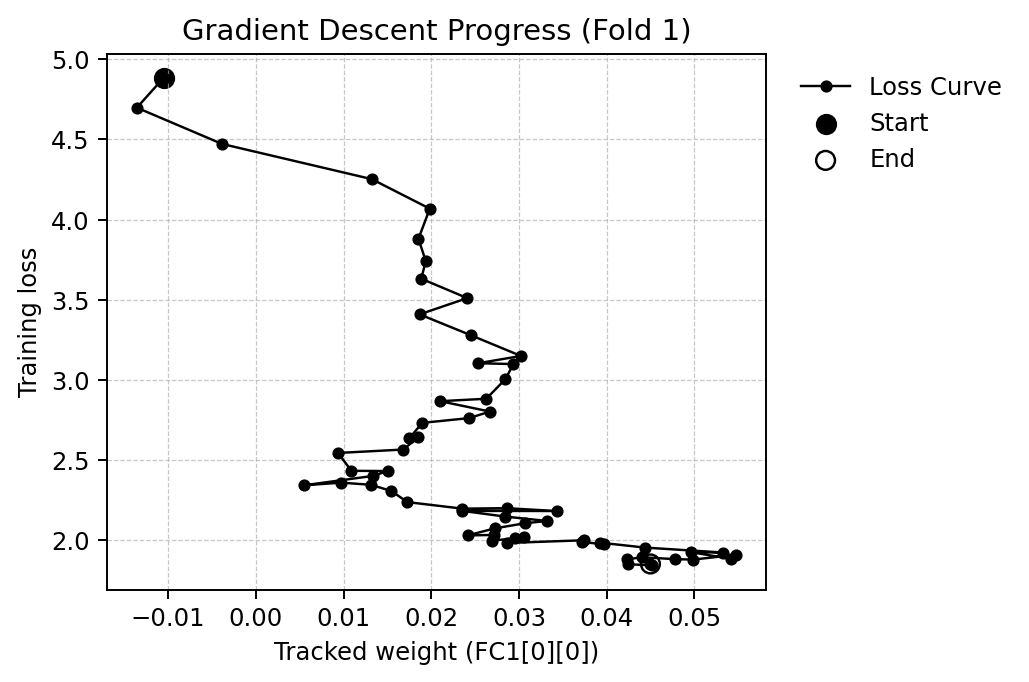


 Starting Fold 2/5

=== Training Fold 2 ===
Epoch 01 | Train Loss: 4.9445 | Val Loss: 4.8837 | Val Acc: 0.0250
Epoch 02 | Train Loss: 4.7624 | Val Loss: 4.5241 | Val Acc: 0.0464
Epoch 03 | Train Loss: 4.4692 | Val Loss: 4.2732 | Val Acc: 0.0643
Epoch 04 | Train Loss: 4.2498 | Val Loss: 4.1188 | Val Acc: 0.0893
Epoch 05 | Train Loss: 4.1160 | Val Loss: 3.9473 | Val Acc: 0.1179
Epoch 06 | Train Loss: 3.9627 | Val Loss: 3.8592 | Val Acc: 0.0929
Epoch 07 | Train Loss: 3.8746 | Val Loss: 3.7050 | Val Acc: 0.1071
Epoch 08 | Train Loss: 3.8001 | Val Loss: 3.6319 | Val Acc: 0.1429
Epoch 09 | Train Loss: 3.6829 | Val Loss: 3.5200 | Val Acc: 0.1643
Epoch 10 | Train Loss: 3.5413 | Val Loss: 3.4158 | Val Acc: 0.1893
Epoch 11 | Train Loss: 3.4964 | Val Loss: 3.3544 | Val Acc: 0.2286
Epoch 12 | Train Loss: 3.4363 | Val Loss: 3.2928 | Val Acc: 0.2107
Epoch 13 | Train Loss: 3.3240 | Val Loss: 3.2515 | Val Acc: 0.2143
Epoch 14 | Train Loss: 3.3303 | Val Loss: 3.1582 | Val Acc: 0.2571
Epoch 15 | Train 

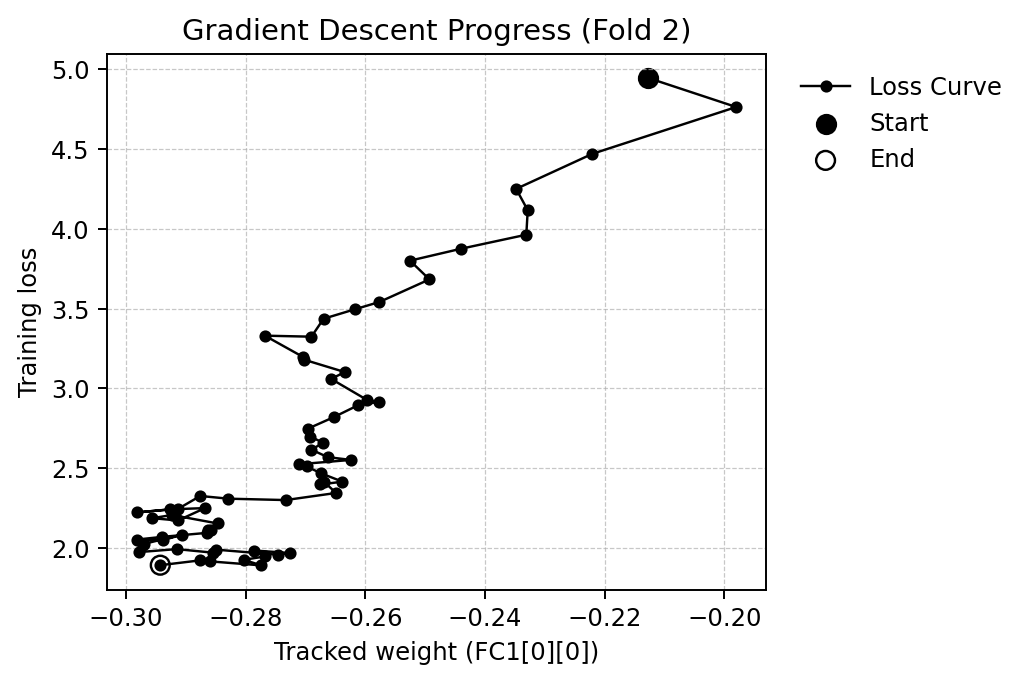


 Starting Fold 3/5

=== Training Fold 3 ===
Epoch 01 | Train Loss: 4.9174 | Val Loss: 4.8138 | Val Acc: 0.0429
Epoch 02 | Train Loss: 4.7237 | Val Loss: 4.4575 | Val Acc: 0.0500
Epoch 03 | Train Loss: 4.3788 | Val Loss: 4.1223 | Val Acc: 0.1000
Epoch 04 | Train Loss: 4.1307 | Val Loss: 3.9680 | Val Acc: 0.1107
Epoch 05 | Train Loss: 3.9469 | Val Loss: 3.8071 | Val Acc: 0.1107
Epoch 06 | Train Loss: 3.8101 | Val Loss: 3.7473 | Val Acc: 0.1250
Epoch 07 | Train Loss: 3.7734 | Val Loss: 3.6024 | Val Acc: 0.1536
Epoch 08 | Train Loss: 3.6301 | Val Loss: 3.5147 | Val Acc: 0.1786
Epoch 09 | Train Loss: 3.5509 | Val Loss: 3.4547 | Val Acc: 0.1786
Epoch 10 | Train Loss: 3.4891 | Val Loss: 3.3486 | Val Acc: 0.1964
Epoch 11 | Train Loss: 3.4086 | Val Loss: 3.3289 | Val Acc: 0.2036
Epoch 12 | Train Loss: 3.3343 | Val Loss: 3.2392 | Val Acc: 0.2357
Epoch 13 | Train Loss: 3.2226 | Val Loss: 3.2409 | Val Acc: 0.2250
Epoch 14 | Train Loss: 3.1817 | Val Loss: 3.0921 | Val Acc: 0.2857
Epoch 15 | Train 

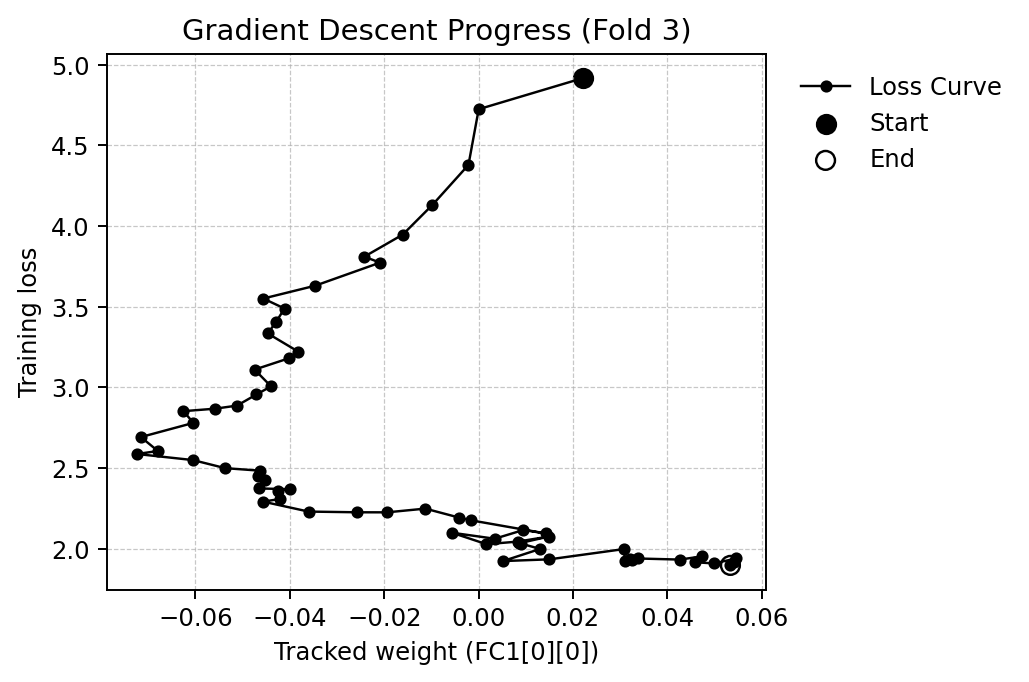


 Starting Fold 4/5

=== Training Fold 4 ===
Epoch 01 | Train Loss: 4.8865 | Val Loss: 4.8024 | Val Acc: 0.0143
Epoch 02 | Train Loss: 4.6916 | Val Loss: 4.5255 | Val Acc: 0.0357
Epoch 03 | Train Loss: 4.3876 | Val Loss: 4.2053 | Val Acc: 0.0893
Epoch 04 | Train Loss: 4.1880 | Val Loss: 4.0403 | Val Acc: 0.0714
Epoch 05 | Train Loss: 4.0147 | Val Loss: 3.8873 | Val Acc: 0.1286
Epoch 06 | Train Loss: 3.9095 | Val Loss: 3.7652 | Val Acc: 0.1214
Epoch 07 | Train Loss: 3.7604 | Val Loss: 3.6553 | Val Acc: 0.1893
Epoch 08 | Train Loss: 3.6508 | Val Loss: 3.5179 | Val Acc: 0.2107
Epoch 09 | Train Loss: 3.5498 | Val Loss: 3.4158 | Val Acc: 0.2179
Epoch 10 | Train Loss: 3.4497 | Val Loss: 3.3326 | Val Acc: 0.2107
Epoch 11 | Train Loss: 3.3416 | Val Loss: 3.2458 | Val Acc: 0.2321
Epoch 12 | Train Loss: 3.2361 | Val Loss: 3.1823 | Val Acc: 0.2929
Epoch 13 | Train Loss: 3.1518 | Val Loss: 3.0955 | Val Acc: 0.2929
Epoch 14 | Train Loss: 3.0769 | Val Loss: 3.0693 | Val Acc: 0.3036
Epoch 15 | Train 

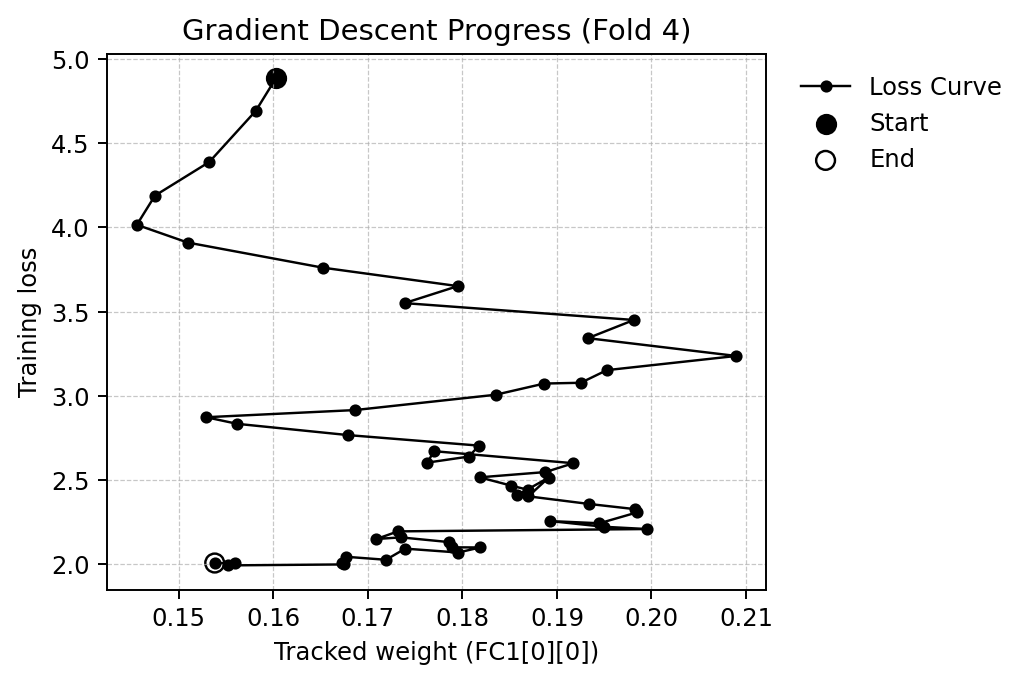


 Starting Fold 5/5

=== Training Fold 5 ===
Epoch 01 | Train Loss: 4.8717 | Val Loss: 4.7491 | Val Acc: 0.0464
Epoch 02 | Train Loss: 4.5773 | Val Loss: 4.3977 | Val Acc: 0.0429
Epoch 03 | Train Loss: 4.2571 | Val Loss: 4.0878 | Val Acc: 0.0393
Epoch 04 | Train Loss: 4.0270 | Val Loss: 3.8658 | Val Acc: 0.0929
Epoch 05 | Train Loss: 3.8723 | Val Loss: 3.6869 | Val Acc: 0.1536
Epoch 06 | Train Loss: 3.7292 | Val Loss: 3.5483 | Val Acc: 0.1500
Epoch 07 | Train Loss: 3.6089 | Val Loss: 3.4269 | Val Acc: 0.1893
Epoch 08 | Train Loss: 3.5140 | Val Loss: 3.3704 | Val Acc: 0.1821
Epoch 09 | Train Loss: 3.4161 | Val Loss: 3.2904 | Val Acc: 0.2107
Epoch 10 | Train Loss: 3.3594 | Val Loss: 3.1956 | Val Acc: 0.3000
Epoch 11 | Train Loss: 3.2350 | Val Loss: 3.1294 | Val Acc: 0.2786
Epoch 12 | Train Loss: 3.2007 | Val Loss: 3.0606 | Val Acc: 0.3143
Epoch 13 | Train Loss: 3.1148 | Val Loss: 2.9883 | Val Acc: 0.3500
Epoch 14 | Train Loss: 3.0785 | Val Loss: 2.9496 | Val Acc: 0.3286
Epoch 15 | Train 

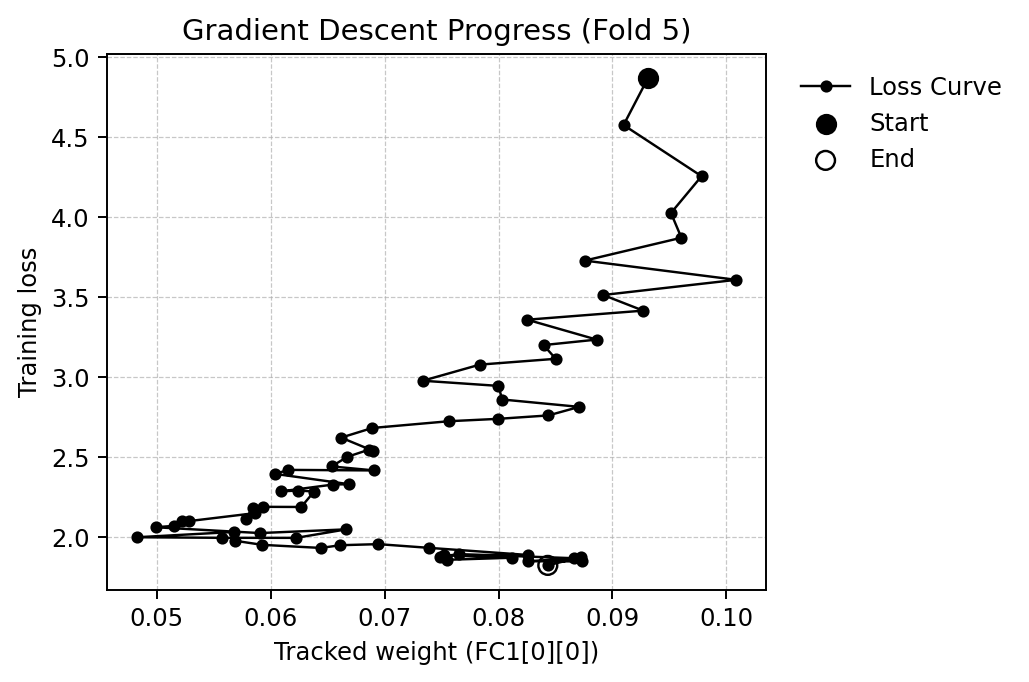

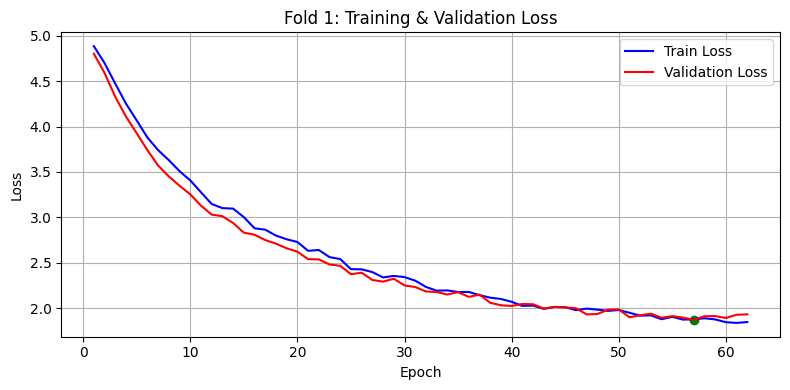

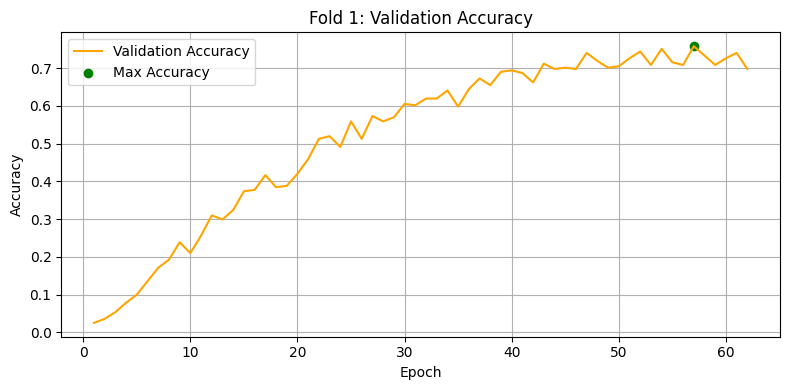

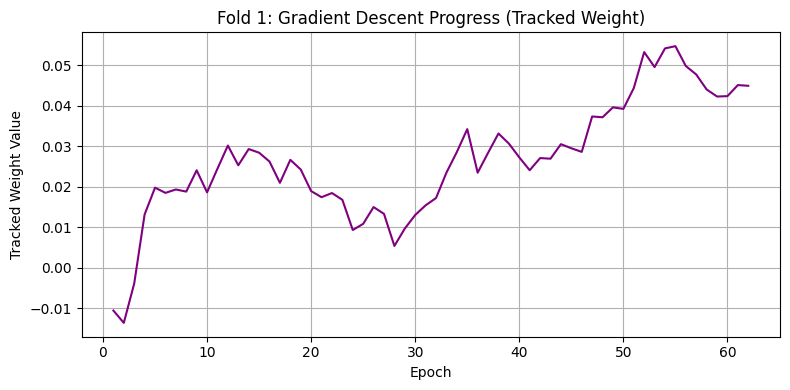

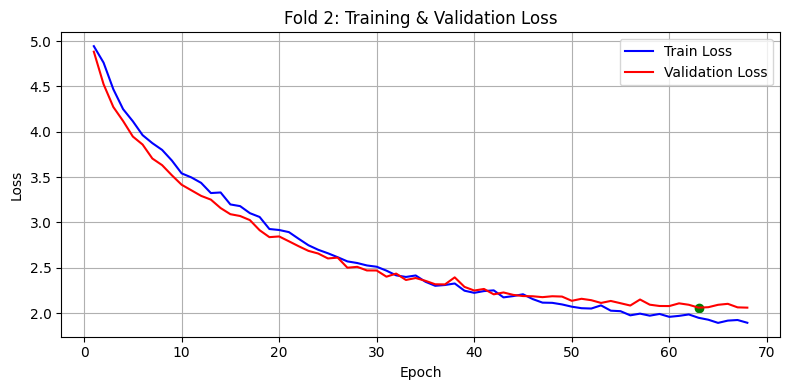

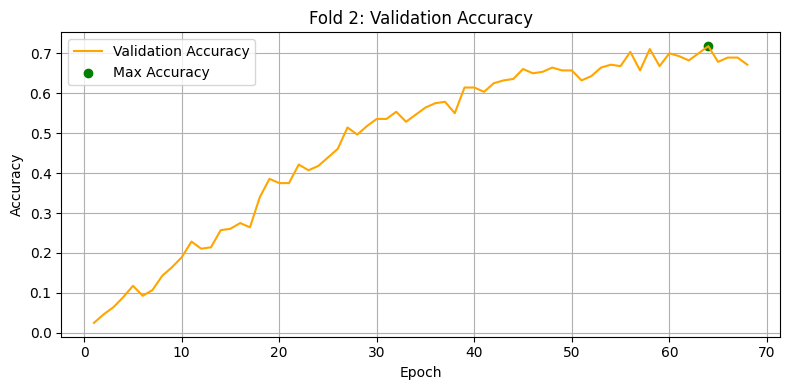

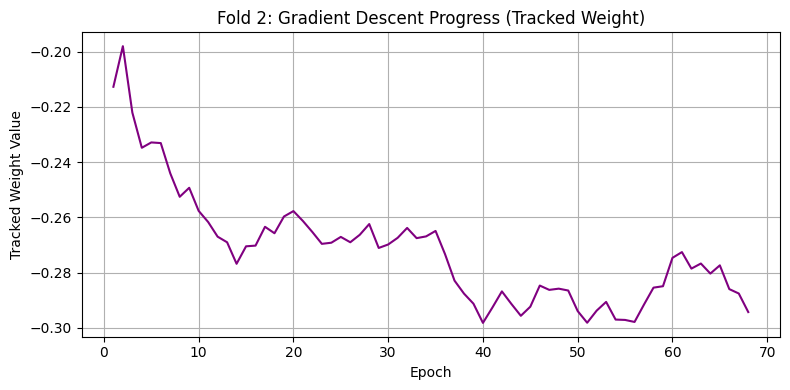

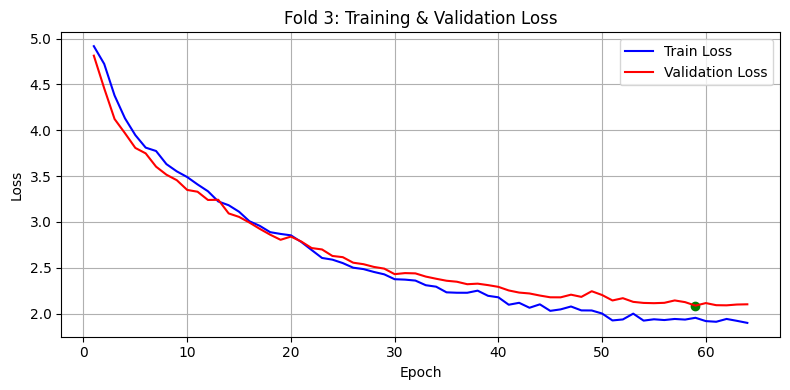

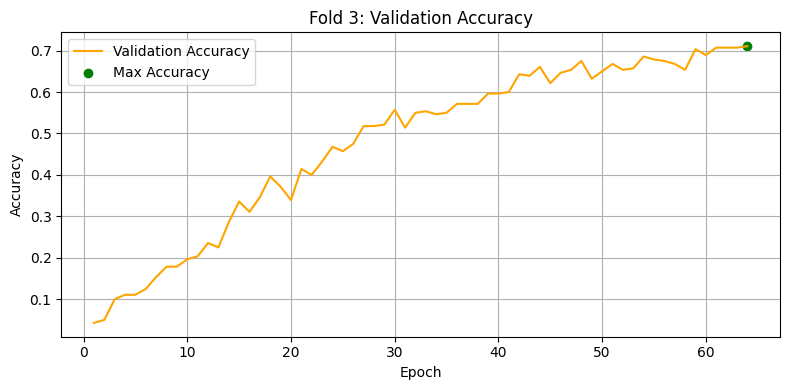

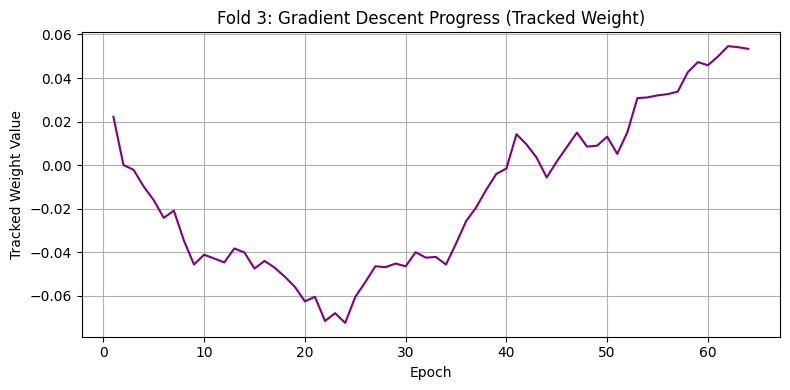

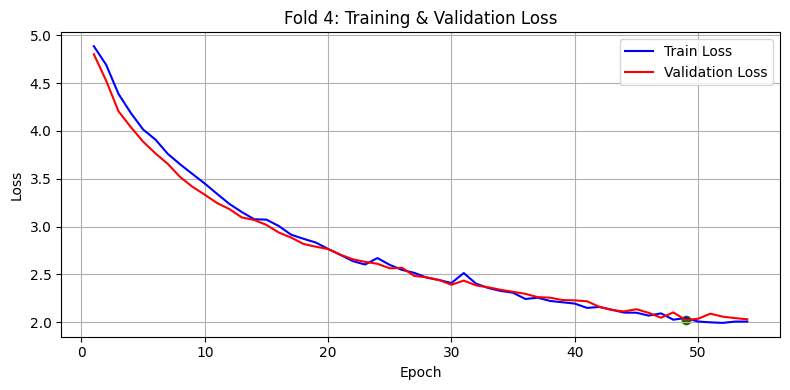

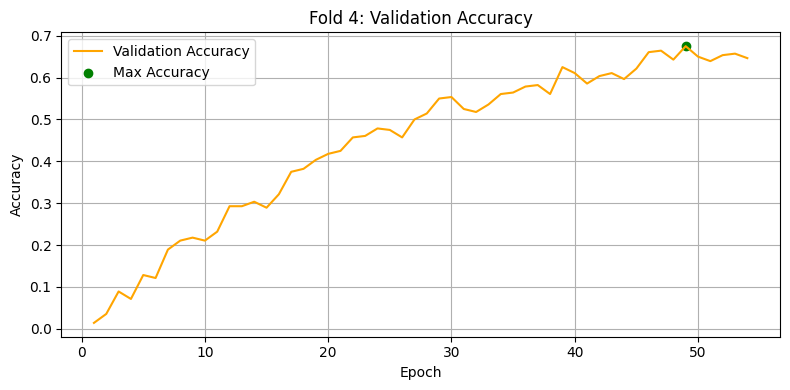

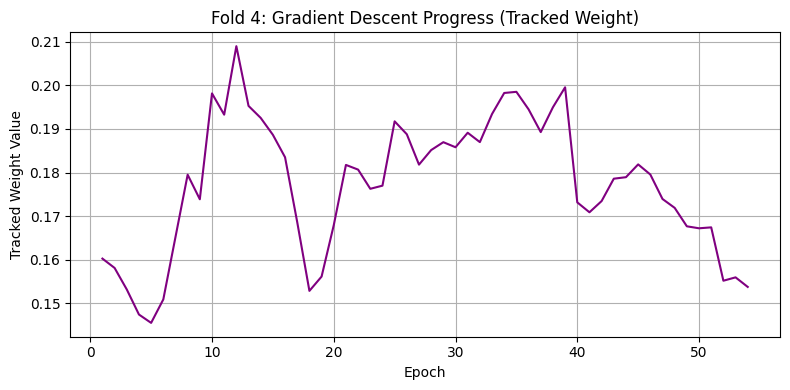

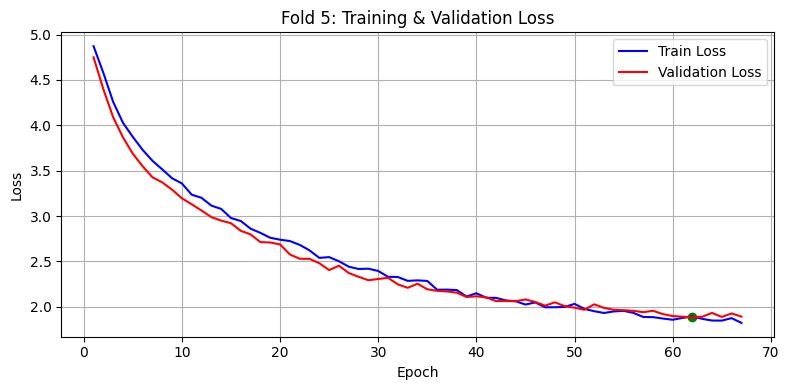

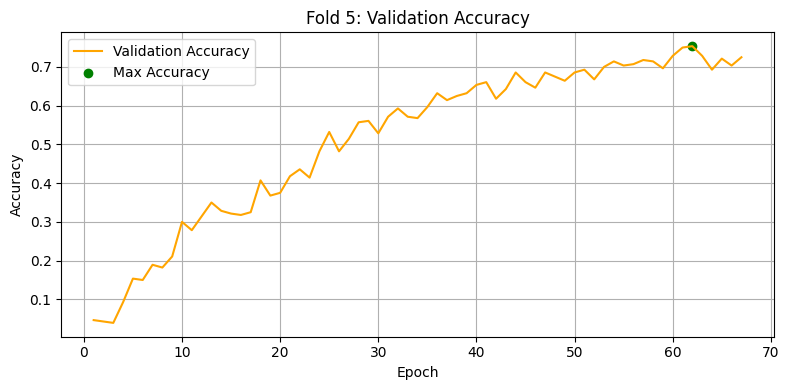

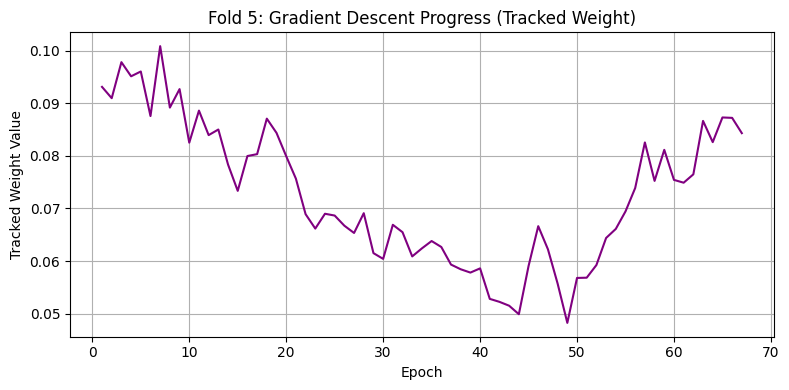

In [ ]:
config = Config()
dp = DataProcessor(config)
data_path = os.path.join("data", "iBeacon_RSSI_Labeled_Processed.csv")

#  Load raw data
X, y, unique_coords, idx_to_coords = dp.load_and_preprocess(data_path)
config.num_classes = len(unique_coords)

# Prepare data
X_seq, y_seq = dp.prepare_sequences(X, y, seq_len=config.sequence_length)

# Train ensemble of 3 folds
models, all_train_losses, all_val_losses, all_val_accuracies, all_tracked_weights = train_localizer_kfold_ensemble(
    X_seq, y_seq, batch_size=16, n_splits=5
)

# Predict with soft voting
test_loader = DataLoader(
    TensorDataset(torch.tensor(X_seq, dtype=torch.float32),
                  torch.tensor(y_seq, dtype=torch.long)),
    batch_size=32, shuffle=False)

# final_preds = ensemble_predict(models, test_loader, config.device)
final_preds = ensemble_predict(models, test_loader, config.device)

# Plot results for each fold
plot_all_folds(all_train_losses, all_val_losses, all_val_accuracies, all_tracked_weights)


# Individual Model Accuracy in Ensemble

In [ ]:
for i, model in enumerate(models, 1):
    preds = ensemble_predict([model], test_loader, config.device)
    print(f"\nModel {i} accuracy: {accuracy_score(y_seq, preds):.4f}")



Model 1 accuracy: 0.8423

Model 2 accuracy: 0.8351

Model 3 accuracy: 0.8237

Model 4 accuracy: 0.7866

Model 5 accuracy: 0.8522


# Model Evaluation Metrics and Classification Report

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report
)
import pandas as pd

# Map class indices back to grid coordinates
pred_coords = [idx_to_coords[int(idx)] for idx in final_preds]
true_coords = [idx_to_coords[int(idx)] for idx in y_seq]

# Summary metrics
acc  = accuracy_score(y_seq, final_preds)
prec = precision_score(y_seq, final_preds, average='weighted', zero_division=0)
rec  = recall_score(y_seq, final_preds, average='weighted', zero_division=0)
f1   = f1_score(y_seq, final_preds, average='weighted', zero_division=0)

metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Score": [acc, prec, rec, f1]
})

print("\n===  Summary Metrics ===")
print(metrics_df.to_string(index=False, float_format="%.4f"))

print("\n===  Classification Report (Per Class) ===")
print(classification_report(
    y_seq, final_preds,
    digits=4,
    zero_division=0
))


===  Summary Metrics ===
   Metric  Score
 Accuracy 0.8965
Precision 0.9338
   Recall 0.8965
 F1 Score 0.9040

===  Classification Report (Per Class) ===
              precision    recall  f1-score   support

           0     0.8571    1.0000    0.9231         6
           1     1.0000    1.0000    1.0000         4
           2     1.0000    0.8571    0.9231        14
           3     0.8000    1.0000    0.8889         4
           4     0.5714    1.0000    0.7273         4
           5     0.5714    1.0000    0.7273         4
           6     1.0000    0.8889    0.9412        18
           7     0.9130    1.0000    0.9545        21
           8     0.8947    0.8947    0.8947        19
           9     0.9167    0.6111    0.7333        18
          10     0.8636    1.0000    0.9268        19
          11     0.9615    0.9259    0.9434        27
          12     0.9130    0.7778    0.8400        27
          13     0.9259    0.9615    0.9434        26
          14     0.8889    1.0000 

# Visualization of Spatial Localization Error via Heatmap

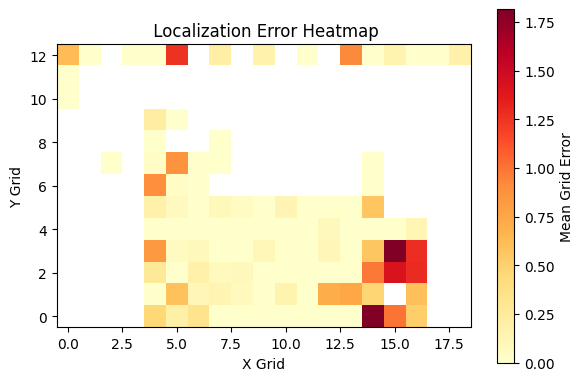

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Build evaluation DataFrame with absolute localization error
eval_df = pd.DataFrame({
    'true_x': [x for x, _ in true_coords],
    'true_y': [y for _, y in true_coords],
    'pred_x': [x for x, _ in pred_coords],
    'pred_y': [y for _, y in pred_coords],
})

eval_df['abs_err'] = np.sqrt(
    (eval_df['true_x'] - eval_df['pred_x'])**2 +
    (eval_df['true_y'] - eval_df['pred_y'])**2
)

# Mean error per grid cell
heat = (
    eval_df
    .groupby(['true_y', 'true_x'])['abs_err']
    .mean()
    .unstack(fill_value=np.nan)
)

# Plot heatmap
plt.figure(figsize=(6, 4))
im = plt.imshow(heat, cmap='YlOrRd', origin='lower')
plt.colorbar(im, label='Mean Grid Error')
plt.title(" Localization Error Heatmap")
plt.xlabel("X Grid")
plt.ylabel("Y Grid")
plt.tight_layout()
plt.show()


# Visualization

In [ ]:
import pandas as pd
import numpy as np
import base64
import plotly.express as px
import plotly.graph_objects as go

timestamps = pd.to_datetime(df['date'])  # ← change 'date' to your actual timestamp column if needed

# This should match the number of sequences you generate
SEQ_LEN = 20
# === 1. Input: true_coords, pred_coords, time_seq ===
data_plot = pd.DataFrame({
    'timestamp': timestamps[SEQ_LEN - 1:],
    'grid_x': [x for x, y in true_coords],
    'grid_y': [y for x, y in true_coords],
    'pred_x': [x for x, y in pred_coords],
    'pred_y': [y for x, y in pred_coords]
})

# === 2. Animate: actual vs predicted ===
animation_data = []
for idx, row in data_plot.iterrows():
    animation_data.append({'timestamp': row['timestamp'], 'x': row['grid_x'], 'y': row['grid_y'], 'Type': 'Actual'})
    animation_data.append({'timestamp': row['timestamp'], 'x': row['pred_x'], 'y': row['pred_y'], 'Type': 'Prediction'})
df_anim = pd.DataFrame(animation_data)

df_anim['timestamp'] = pd.to_datetime(df_anim['timestamp'])
df_anim = df_anim.sort_values('timestamp')

# === 3. Load layout image (adjust path as needed) ===
with open("iBeacon_Layout.jpg", "rb") as image_file:  # Use your own file path
    encoded_image = base64.b64encode(image_file.read()).decode()
image_source = f"data:image/jpeg;base64,{encoded_image}"

# === 4. Plot animated scatter ===
fig = px.scatter(
    df_anim,
    x='x', y='y',
    animation_frame='timestamp',
    color='Type',
    symbol='Type',
    color_discrete_map={
        'Prediction': 'red',
        'Actual': 'blue'
    },
    symbol_map={
        'Prediction': 'diamond-open',
        'Actual': 'circle'
    },
    labels={'x': 'X Coordinate', 'y': 'Y Coordinate'},
    range_x=[0, 25],
    range_y=[0, 20],
    width=1000,
    height=800
)




for trace in fig.data:
    if trace.name == 'Prediction':
        trace.marker.size = 15  # Make it bigger
    elif trace.name == 'Actual':
        trace.marker.size = 8   # Slightly smaller

fig.update_layout(
    images=[dict(
        source=image_source,
        xref="x", yref="y",
        x=0, y=20,  # image starts from top-left
        sizex=25, sizey=20,
        sizing="stretch",
        opacity=1,
        layer="below"
    )],
    title="Indoor Position Tracking: Actual vs Predicted Paths"
)

fig.show()


# Visualization with different Layout

In [ ]:
import pandas as pd
import numpy as np
import base64
import plotly.express as px
import plotly.graph_objects as go

timestamps = pd.to_datetime(df['date'])  # ← change 'date' to your actual timestamp column if needed

# This should match the number of sequences you generate
SEQ_LEN = 20
# === 1. Input: true_coords, pred_coords, time_seq ===
data_plot = pd.DataFrame({
    'timestamp': timestamps[SEQ_LEN - 1:],
    'grid_x': [x for x, y in true_coords],
    'grid_y': [y for x, y in true_coords],
    'pred_x': [x for x, y in pred_coords],
    'pred_y': [y for x, y in pred_coords]
})

# === 2. Animate: actual vs predicted ===
animation_data = []
for idx, row in data_plot.iterrows():
    animation_data.append({'timestamp': row['timestamp'], 'x': row['grid_x'], 'y': row['grid_y'], 'Type': 'Actual'})
    animation_data.append({'timestamp': row['timestamp'], 'x': row['pred_x'], 'y': row['pred_y'], 'Type': 'Prediction'})
df_anim = pd.DataFrame(animation_data)

df_anim['timestamp'] = pd.to_datetime(df_anim['timestamp'])
df_anim = df_anim.sort_values('timestamp')

# === 3. Load layout image (adjust path as needed) ===
with open("3d House.jpg", "rb") as image_file:  # Use your own file path
    encoded_image = base64.b64encode(image_file.read()).decode()
image_source = f"data:image/jpeg;base64,{encoded_image}"

# === 4. Plot animated scatter ===
fig = px.scatter(
    df_anim,
    x='x', y='y',
    animation_frame='timestamp',
    color='Type',
    symbol='Type',
    color_discrete_map={
        'Prediction': 'red',
        'Actual': 'blue'
    },
    symbol_map={
        'Prediction': 'diamond-open',
        'Actual': 'circle'
    },
    labels={'x': 'X Coordinate', 'y': 'Y Coordinate'},
    range_x=[0, 25],
    range_y=[0, 20],
    width=1000,
    height=800
)


BEACON_COORDS = {
    "b3001": (7, 13),  # Bedroom (top left)
    "b3002": (18, 14), # Master bedroom (top right)
    "b3003": (7, 3),   # Patio
    "b3004": (9, 8),   # Common Area Living room

    "b3005": (4, 9),   # Left Balcony
    "b3006": (16, 9),  # Dining Hall
    "b3007": (12, 14), # Rest Room
    "b3008": (21, 8),  # Right Balcony

    "b3009": (3, 6),   # Store room
    "b3010": (11, 4),  # Entrance
    "b3011": (17,5),   # Kitchen
    "b3012": (14, 16), # Laundry
    "b3013": (23, 4)   # Dish Washing
}

BEACON_ROOM_MAP = {
    "b3001": "Bedroom ",
    "b3002": "Master Bedroom",
    "b3003": "Patio",
    "b3004": "Common Area",
    "b3005": "Left Balcony ",
    "b3006": "Dining Hall",
    "b3007": "Rest Room",
    "b3008": "Right Balcony",
    "b3009": "Entrance",
    "b3010": "Store Room",
    "b3011": "Kitchen",
    "b3012": "Laundry",
    "b3013": "Dish Washing"
}

for beacon_id, coord in BEACON_COORDS.items():
    room_name = BEACON_ROOM_MAP[beacon_id]
    fig.add_trace(go.Scatter(
        x=[coord[0]],
        y=[coord[1]],
        mode='markers',

        marker=dict(color='green', size=10),
        text=[room_name],             # shows room name above dot
        textposition="top center",
        name=room_name                # appears in legend
    ))


for trace in fig.data:
    if trace.name == 'Prediction':
        trace.marker.size = 15  # Make it bigger
    elif trace.name == 'Actual':
        trace.marker.size = 8   # Slightly smaller

fig.update_layout(
    images=[dict(
        source=image_source,
        xref="x", yref="y",
        x=0, y=20,  # image starts from top-left
        sizex=25, sizey=20,
        sizing="stretch",
        opacity=1,
        layer="below"
    )],
    title="Indoor Position Tracking: Actual vs Predicted Paths with Different Layout"
)

fig.show()


# SVM,KNN and RF

In [ ]:
import torch

# Assuming input is a NumPy array of shape (samples, time_steps, features)
autoencoder.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)

    # If input was (N, 10, 13), and encoder expects (N, 13, 10)
    X_tensor = X_tensor.permute(0, 2, 1)  # Adjust only if needed

    # Pass through encoder
    X_encoded = autoencoder.encoder(X_tensor).cpu().numpy()


In [ ]:
X_encoded = X_encoded.reshape(X_encoded.shape[0], -1)  # → (1410, 1280)
print("X_encoded reshaped:", X_encoded.shape)


X_encoded reshaped: (1401, 2560)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)

# Define models
models = {
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier()
}


from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

print("KNN Results:")
print(classification_report(y_test, y_pred_knn, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))




KNN Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1
           6       0.11      0.25      0.15         4
           7       0.00      0.00      0.00         4
           8       0.50      0.50      0.50         4
           9       0.22      0.50      0.31         4
          10       0.50      0.50      0.50         4
          11       1.00      0.40      0.57         5
          12       0.60      0.60      0.60         5
          13       0.43      0.60      0.50         5
          14       0.67      1.00      0.80         2
          15       0.50      0.33      0.40         3
          16       0.50      1.00      0.67         1
          17  

In [ ]:
from sklearn.svm import SVC
model_svm = SVC()
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score
print("SVM Results:")
print(classification_report(y_test, y_pred_svm, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))


SVM Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.50      0.67      0.57         3
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         4
           7       0.33      0.25      0.29         4
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         4
          11       0.29      0.40      0.33         5
          12       0.19      0.60      0.29         5
          13       0.33      0.40      0.36         5
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         1
          17  

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.50      0.67      0.57         3
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.33      0.50      0.40         4
           7       0.33      0.50      0.40         4
           8       1.00      0.25      0.40         4
           9       1.00      0.25      0.40         4
          10       0.33      0.25      0.29         4
          11       0.43      0.60      0.50         5
          12       1.00      0.60      0.75         5
          13       0.50      1.00      0.67         5
          14       1.00      0.50      0.67         2
          15       0.40      0.67      0.50         3
          16       0.00      0.00      0.00         1
    

Number of unique classes: 105
Sample count per class (sorted):
Class 0: 6 samples
Class 1: 4 samples
Class 2: 14 samples
Class 3: 4 samples
Class 4: 4 samples
Class 5: 4 samples
Class 6: 18 samples
Class 7: 21 samples
Class 8: 19 samples
Class 9: 18 samples
Class 10: 19 samples
Class 11: 27 samples
Class 12: 27 samples
Class 13: 26 samples
Class 14: 8 samples
Class 15: 14 samples
Class 16: 5 samples
Class 17: 16 samples
Class 18: 22 samples
Class 19: 24 samples
Class 20: 32 samples
Class 21: 19 samples
Class 22: 29 samples
Class 23: 27 samples
Class 24: 9 samples
Class 25: 6 samples
Class 26: 8 samples
Class 27: 6 samples
Class 28: 9 samples
Class 29: 23 samples
Class 30: 34 samples
Class 31: 25 samples
Class 32: 22 samples
Class 33: 11 samples
Class 34: 12 samples
Class 35: 6 samples
Class 36: 10 samples
Class 37: 13 samples
Class 38: 20 samples
Class 39: 14 samples
Class 40: 22 samples
Class 41: 3 samples
Class 42: 2 samples
Class 43: 10 samples
Class 44: 10 samples
Class 45: 14 samp

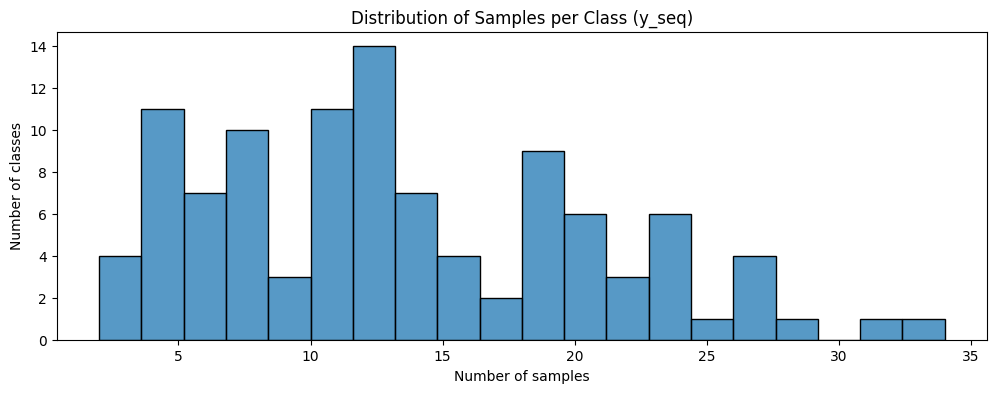

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Count occurrences of each class
class_counts = Counter(y_seq)

# Print number of classes and sample counts
print(f"Number of unique classes: {len(class_counts)}")
print("Sample count per class (sorted):")
for cls, count in sorted(class_counts.items()):
    print(f"Class {cls}: {count} samples")

# Optional: plot distribution
plt.figure(figsize=(12, 4))
sns.histplot(list(class_counts.values()), bins=20)
plt.title("Distribution of Samples per Class (y_seq)")
plt.xlabel("Number of samples")
plt.ylabel("Number of classes")
plt.show()


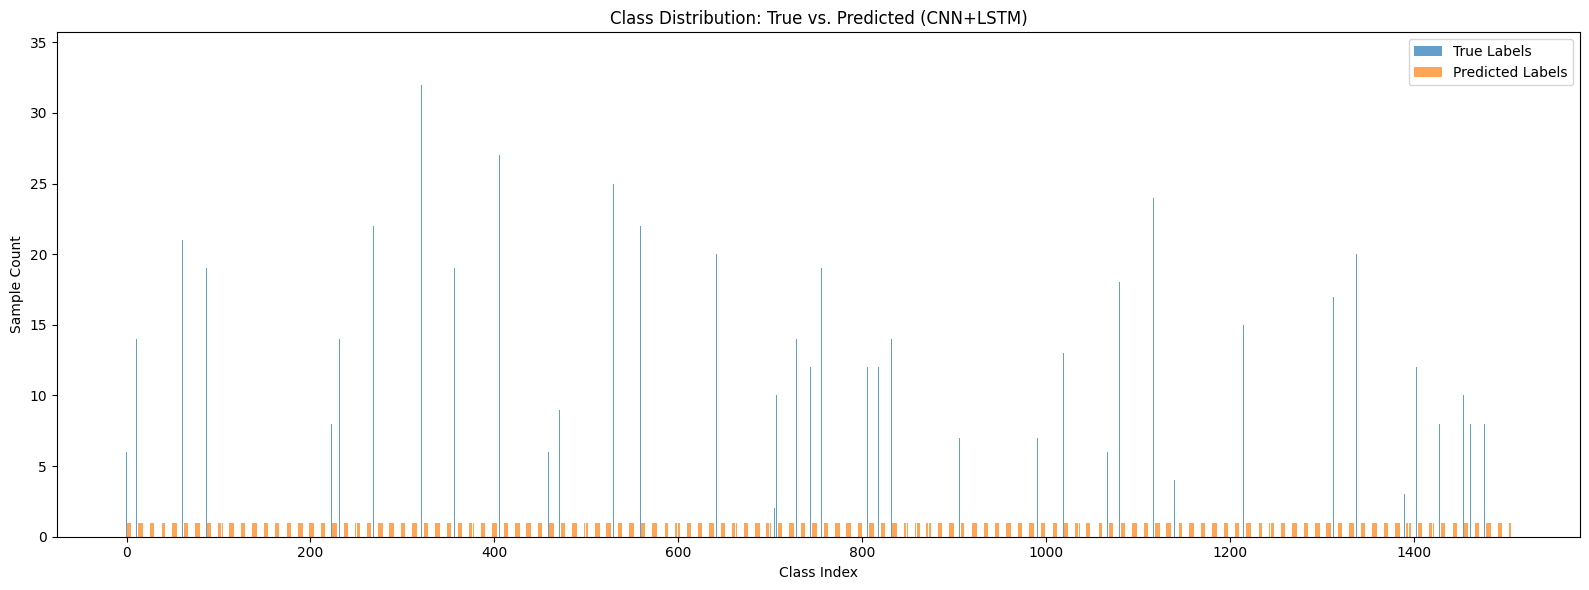

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Count occurrences
true_counts = Counter(y_seq)
pred_counts = Counter(preds)

# Unified set of class indices
all_classes = sorted(set(true_counts.keys()).union(set(pred_counts.keys())))

# Aligned values
true_vals = [true_counts.get(cls, 0) for cls in all_classes]
pred_vals = [pred_counts.get(cls, 0) for cls in all_classes]

# Plot
plt.figure(figsize=(16, 6))
bar_width = 0.4
x = range(len(all_classes))

plt.bar([i - bar_width/2 for i in x], true_vals, width=bar_width, alpha=0.7, label="True Labels")
plt.bar([i + bar_width/2 for i in x], pred_vals, width=bar_width, alpha=0.7, label="Predicted Labels")
plt.xlabel("Class Index")
plt.ylabel("Sample Count")
plt.title("Class Distribution: True vs. Predicted (CNN+LSTM)")
plt.legend()
plt.tight_layout()
plt.show()


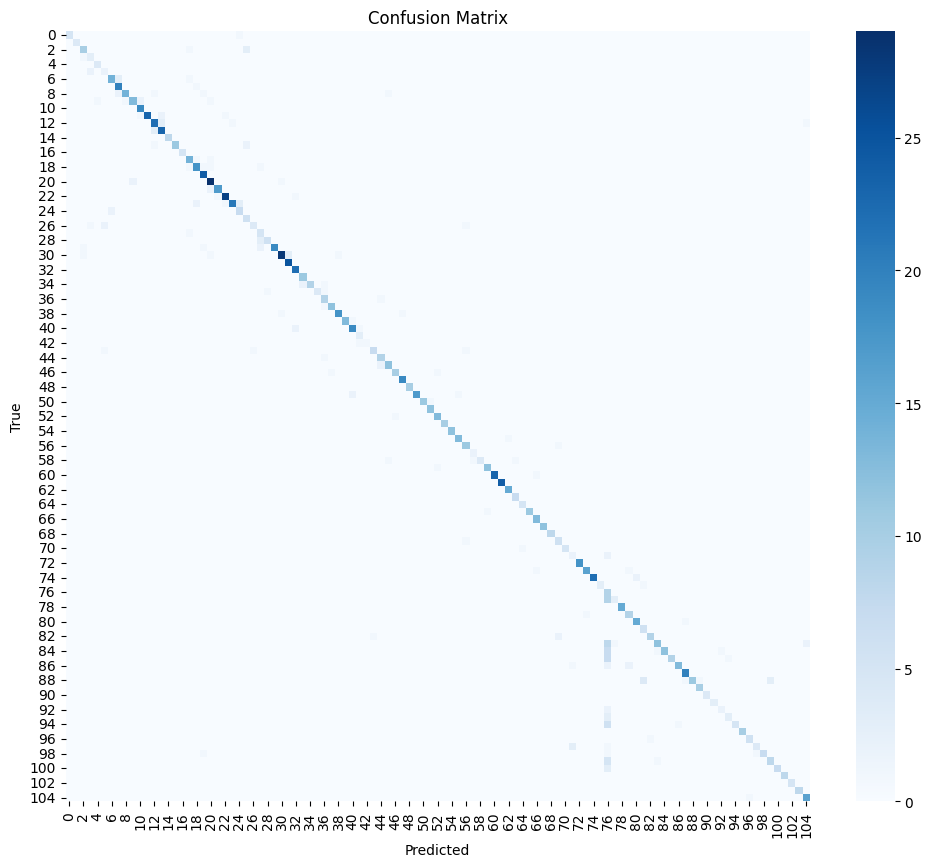

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_seq, preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", annot=False, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

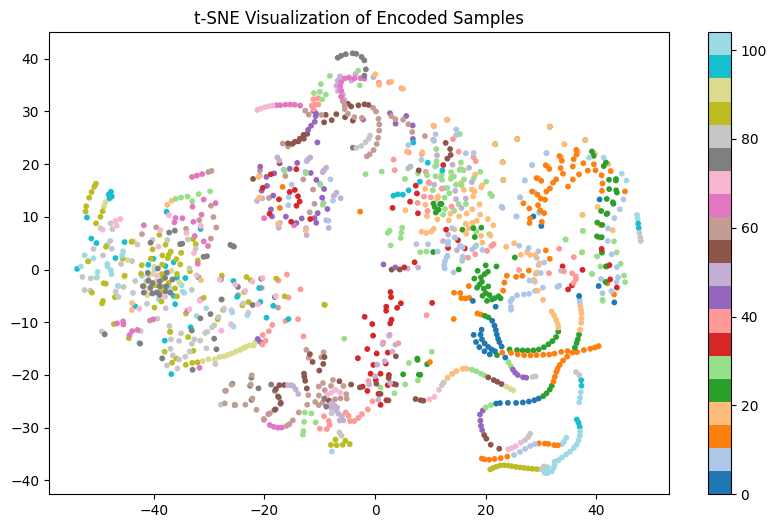

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_encoded)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_seq, cmap='tab20', s=10)
plt.title("t-SNE Visualization of Encoded Samples")
plt.colorbar(scatter)
plt.show()


# Setup (imports, seeds, device/AMP helper)

In [18]:
# --- Imports
import os, random, numpy as np, torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib
from contextlib import nullcontext
from torch.cuda.amp import GradScaler

# --- Reproducibility
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        try: torch.set_float32_matmul_precision("high")
        except: pass

# --- Device + AMP helper (no warnings on CPU)
def make_device_and_amp(config):
    is_cuda = torch.cuda.is_available()
    cfg_dev = getattr(config, "device", None)
    device  = ("cuda" if is_cuda else "cpu") if cfg_dev is None else (cfg_dev if (cfg_dev=="cuda" and is_cuda) else "cpu")
    use_amp = bool(getattr(config, "amp", True)) and (device == "cuda")
    def amp_ctx(): return torch.amp.autocast("cuda") if use_amp else nullcontext()
    num_workers = getattr(config, "num_workers", 2 if is_cuda else 0)
    pin_memory  = bool(getattr(config, "pin_memory", True)) and is_cuda
    return device, use_amp, amp_ctx, num_workers, pin_memory

set_seed(42)


# Config + (optional) tuned hyperparams

In [19]:
class Config:
    # dirs
    model_dir = "models"
    # core
    device = None            # autodetect
    learning_rate = 1e-3
    epochs = 75
    latent_dim = 8
    # regularization & sched
    label_smoothing = 0.0    # max accuracy -> 0.0 (you can set 0.05 if you want)
    clip_norm = 5.0
    weight_decay = 1e-4
    scheduler = "plateau"    # 'plateau' | 'cosine'
    scheduler_factor = 0.7
    scheduler_patience = 6
    amp = True
    # AE pretrain (per-fold, train-only)
    ae_epochs = 35
    ae_denoising = True
    # optimizer split LRs
    enc_lr_mult = 0.7
    # dataloader
    num_workers = None
    pin_memory  = None

# Optional: override from a tuned set
BEST_HP = {
    # "learning_rate": 1e-3,
    # "enc_lr_mult":   0.7,
    # "label_smoothing": 0.0,
    # "clip_norm": 5.0,
    # "ae_epochs": 35,
    # "ae_denoising": True,
    # "scheduler": "plateau", "scheduler_factor": 0.7, "scheduler_patience": 6,
    # "amp": True,
}


# Models (AE + Localizer with bi-LSTM + attention, robust to [B,T,F]/[B,F,T])

In [20]:
class RSSIAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, 32, 3, padding=1), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(0.2),
            nn.Conv1d(32, 64, 3, padding=1),       nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.2),
            nn.Conv1d(64, 128, 3, padding=1),      nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
        )
        self.bottleneck = nn.Conv1d(128, 128, 1)
        self.decoder = nn.Sequential(
            nn.Conv1d(128, 64, 3, padding=1),  nn.BatchNorm1d(64),  nn.ReLU(),
            nn.Conv1d(64, 32, 3, padding=1),   nn.BatchNorm1d(32),  nn.ReLU(),
            nn.Conv1d(32, input_dim, 3, padding=1)
        )

    def forward(self, x_ft):  # [B,F,T]
        z = self.encoder(x_ft)
        z = self.bottleneck(z)
        return self.decoder(z)

class IndoorLocalizer(nn.Module):
    def __init__(self, input_dim, num_classes, pretrained_encoder=None):
        super().__init__()
        self.input_dim = input_dim
        if pretrained_encoder is not None:
            self.encoder = pretrained_encoder
            enc_in = None
            for m in self.encoder.modules():
                if isinstance(m, nn.Conv1d): enc_in = m.in_channels; break
            self._enc_in_channels = enc_in or input_dim
        else:
            self.encoder = nn.Sequential(
                nn.Conv1d(input_dim, 32, 3, padding=1), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(0.2),
                nn.Conv1d(32, 64, 3, padding=1),       nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.2),
                nn.Conv1d(64, 128, 3, padding=1),      nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            )
            self._enc_in_channels = input_dim

        self.lstm = nn.LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
        self.attn = nn.Linear(256, 1)
        self.fc1  = nn.Linear(256, 64)
        self.fc2  = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # accept [B,T,F] or [B,F,T]; match encoder channels
        if x.dim()!=3: raise ValueError(f"expected 3D, got {x.shape}")
        Cexp = self._enc_in_channels
        if x.size(1)==Cexp: x_ch = x
        elif x.size(2)==Cexp: x_ch = x.permute(0,2,1)
        else: raise ValueError(f"input {x.shape} incompatible with channels={Cexp}")

        x = self.encoder(x_ch)      # [B,128,T]
        x = x.permute(0,2,1)        # [B,T,128]
        x, _ = self.lstm(x)         # [B,T,256]
        x = self.dropout(x)
        w = torch.softmax(self.attn(x).squeeze(-1), dim=1)  # [B,T]
        x = (x * w.unsqueeze(-1)).sum(dim=1)                # [B,256]
        x = self.relu(self.fc1(x)); x = self.dropout(x)
        return self.fc2(x)


# Training (leak-safe scaler + AE pretrain, diff LRs, AMP, early stop)

In [21]:
def train_one_fold(X_train, y_train, X_val, y_val, batch_size, fold):
    # config + overrides
    config = Config()
    for k,v in BEST_HP.items(): setattr(config, k, v)
    device, use_amp, amp_ctx, num_workers, pin_memory = make_device_and_amp(config)
    os.makedirs(config.model_dir, exist_ok=True); os.makedirs("scalers", exist_ok=True)

    set_seed(getattr(config, "seed", 42))

    T, F = X_train.shape[1], X_train.shape[2]
    num_classes = int(len(np.unique(y_train)))

    # --- scaler (fit on TRAIN only)
    scaler = StandardScaler().fit(X_train.reshape(-1, F))
    X_train = scaler.transform(X_train.reshape(-1, F)).reshape(-1, T, F)
    X_val   = scaler.transform(X_val.reshape(-1, F)).reshape(-1, T, F)
    joblib.dump(scaler, f"scalers/scaler_fold{fold}.pkl")

    # --- AE pretrain (TRAIN only), Conv1d expects [B,F,T]
    ae = RSSIAutoencoder(input_dim=F, latent_dim=config.latent_dim).to(device)
    ae_crit = nn.MSELoss()
    ae_opt  = optim.Adam(ae.parameters(), lr=1e-3)
    ae_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)),
                           batch_size=128, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    scaler_ae = GradScaler(enabled=use_amp)

    ae.train()
    for _ in range(int(config.ae_epochs)):
        for (xb,) in ae_loader:
            xb = xb.to(device).permute(0,2,1)  # [B,T,F] -> [B,F,T]
            xin = xb + 0.05*torch.randn_like(xb) if config.ae_denoising else xb
            with amp_ctx():
                recon = ae(xin)
                loss  = ae_crit(recon, xb)
            ae_opt.zero_grad(set_to_none=True)
            scaler_ae.scale(loss).backward()
            scaler_ae.step(ae_opt); scaler_ae.update()

    encoder = ae.encoder
    for p in encoder.parameters(): p.requires_grad = True

    # --- classifier
    model = IndoorLocalizer(input_dim=F, num_classes=num_classes, pretrained_encoder=encoder).to(device)

    class_weights = torch.tensor(
        compute_class_weight('balanced', classes=np.unique(y_train), y=y_train),
        dtype=torch.float32, device=device
    )
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=getattr(config, "label_smoothing", 0.0))

    enc_params  = list(model.encoder.parameters())
    head_params = [p for n,p in model.named_parameters() if not n.startswith("encoder.")]
    optimizer = optim.Adam(
        [{"params": enc_params,  "lr": config.learning_rate * config.enc_lr_mult},
         {"params": head_params, "lr": config.learning_rate}],
        weight_decay=config.weight_decay
    )

    if config.scheduler == "cosine":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)
        on_plateau = False
    else:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=config.scheduler_factor, patience=config.scheduler_patience)
        on_plateau = True

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.long)),
                              batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    val_loader   = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                            torch.tensor(y_val, dtype=torch.long)),
                              batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

    best_val, patience, no_improve = float('inf'), 5, 0
    final_ckpt = os.path.join(config.model_dir, f"model_fold{fold}.pth")
    scaler_cls = GradScaler(enabled=use_amp)
    train_losses, val_losses, val_accuracies = [], [], []

    print(f"\n=== Training Fold {fold} ===")
    for epoch in range(1, config.epochs+1):
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch-1}")
            break

        # Train
        model.train(); total = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            # optional: tiny train-time noise
            # xb = xb + 0.02*torch.randn_like(xb)

            with amp_ctx():
                out = model(xb)
                loss = criterion(out, yb)

            optimizer.zero_grad(set_to_none=True)
            scaler_cls.scale(loss).backward()
            scaler_cls.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.clip_norm)
            scaler_cls.step(optimizer); scaler_cls.update()
            total += loss.item()

        avg_train = total / max(1, len(train_loader))
        train_losses.append(avg_train)

        # Validate
        model.eval(); vloss, correct, total_n = 0.0, 0, 0
        preds_all, y_all = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                with amp_ctx():
                    out = model(xb)
                    loss = criterion(out, yb)
                vloss += loss.item()
                preds = out.argmax(1)
                correct += (preds==yb).sum().item()
                total_n += yb.numel()
                preds_all.append(preds.cpu().numpy()); y_all.append(yb.cpu().numpy())

        avg_val = vloss / max(1, len(val_loader))
        val_acc = correct / max(1, total_n)
        val_losses.append(avg_val); val_accuracies.append(val_acc)
        yhat = np.concatenate(preds_all); ytrue = np.concatenate(y_all)
        mf1  = f1_score(ytrue, yhat, average='macro', zero_division=0)

        print(f"Epoch {epoch:02d} | Train {avg_train:.4f} | Val {avg_val:.4f} | Acc {val_acc:.4f} | mF1 {mf1:.4f}")

        if on_plateau: scheduler.step(avg_val)
        else:          scheduler.step()

        if avg_val < best_val:
            best_val = avg_val; no_improve = 0
            torch.save(model.state_dict(), final_ckpt)
        else:
            no_improve += 1

    model.load_state_dict(torch.load(final_ckpt, map_location=device))
    return model, train_losses, val_losses, val_accuracies


# CV training, OOF metrics, ensemble, reports, plots

In [22]:
# --- Helper: choose safe n_splits (stratified)
def make_stratified_splitter(y, desired_splits=5, seed=42):
    _, counts = np.unique(y, return_counts=True)
    n_splits = max(2, min(desired_splits, int(counts.min())))
    print(f"Using n_splits = {n_splits} (min per class = {counts.min()})")
    return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

# --- Ensemble (logit average)
def ensemble_logits(models, X, batch_size=64, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.zeros(len(X), dtype=torch.long))
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    all_model_logits = []
    for m in models:
        m.eval(); logits=[]
        with torch.no_grad():
            for xb,_ in dl:
                xb = xb.to(device)
                logits.append(m(xb).cpu())
        all_model_logits.append(torch.cat(logits,0))
    return torch.stack(all_model_logits).mean(0)

def ensemble_predict(models, X, **kw):
    L = ensemble_logits(models, X, **kw)
    return L.argmax(1).numpy(), L

# --- Train CV and collect OOF predictions
def crossval_train_and_oof(X, y, batch_size=16, desired_splits=5, seed=42):
    skf = make_stratified_splitter(y, desired_splits, seed)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    models, fold_indices = [], []
    all_train_losses, all_val_losses, all_val_accuracies = [], [], []
    oof_pred = np.empty_like(y)

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]
        model, trL, vaL, vaA = train_one_fold(X_tr, y_tr, X_va, y_va, batch_size=batch_size, fold=fold)
        models.append(model); fold_indices.append((tr_idx, va_idx))
        all_train_losses.append(trL); all_val_losses.append(vaL); all_val_accuracies.append(vaA)
        y_hat, _ = ensemble_predict([model], X_va, device=device)  # OOF for this fold
        oof_pred[va_idx] = y_hat

    acc = accuracy_score(y, oof_pred)
    mf1 = f1_score(y, oof_pred, average='macro', zero_division=0)
    print("OOF Accuracy:", round(acc,4), "OOF Macro-F1:", round(mf1,4))
    return models, fold_indices, all_train_losses, all_val_losses, all_val_accuracies, oof_pred, acc, mf1

# === RUN CV TRAIN ===
models, fold_indices, all_train_losses, all_val_losses, all_val_accuracies, oof_pred, oof_acc, oof_mf1 = \
    crossval_train_and_oof(X_seq, y_seq, batch_size=16, desired_splits=5, seed=42)

# --- Classification report (OOF)
os.makedirs("reports", exist_ok=True)
cr_txt = classification_report(y_seq, oof_pred, digits=4, zero_division=0)
print(cr_txt)
with open("reports/classification_report_OOF.txt","w") as f: f.write(cr_txt)
print("Saved → reports/classification_report_OOF.txt")

# --- Confusion matrix (normalized)
def plot_confmat(y_true, y_pred, normalize='true', savepath=None, max_classes=None):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    if max_classes and cm.shape[0] > max_classes:
        cm = cm[:max_classes,:max_classes]
    fig = plt.figure(figsize=(10,8))
    im = plt.imshow(cm, aspect='auto'); plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f'Confusion Matrix (normalize={normalize})'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout()
    if savepath: fig.savefig(savepath, dpi=200); print("Saved →", savepath)
    plt.show()

plot_confmat(y_seq, oof_pred, normalize='true', savepath='reports/confmat_oof.png')

# --- Learning curves (per-fold + aggregate)
for i,(trL,vaL) in enumerate(zip(all_train_losses, all_val_losses),1):
    fig = plt.figure()
    plt.plot(trL, label='Train'); plt.plot(vaL, label='Val')
    plt.title(f'Fold {i} Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout()
    fig.savefig(f"reports/loss_curve_fold{i}.png", dpi=200); plt.close(fig)

max_len = max(len(v) for v in all_val_losses)
def pad_to(arr, L): return np.array([v + [v[-1]]*(L-len(v)) for v in arr], dtype=float)
tr = pad_to(all_train_losses, max_len); va = pad_to(all_val_losses, max_len)
fig = plt.figure()
for name,M in [('Train',tr),('Val',va)]:
    med = np.median(M,0); q1 = np.percentile(M,25,0); q3 = np.percentile(M,75,0); x = np.arange(len(med))
    plt.plot(x, med, label=f'{name} median'); plt.fill_between(x,q1,q3,alpha=0.2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Learning Curves (median ± IQR)'); plt.legend(); plt.tight_layout()
fig.savefig("reports/loss_curves_aggregate.png", dpi=200); plt.close(fig)
print("Saved plots in reports/")

# --- Final summary
per_fold_best_acc = [round(max(v),4) for v in all_val_accuracies]
print("Num classes:", len(np.unique(y_seq)))
print("Per-fold best Acc:", per_fold_best_acc)
print("OOF Acc / Macro-F1:", round(oof_acc,4), "/", round(oof_mf1,4))
print("BEST_HP used:", BEST_HP)


NameError: name 'X_seq' is not defined

# Plotly: interactive heatmap of mean error per grid

In [ ]:
import plotly.express as px

# `heat` is a DataFrame indexed by true_y with columns true_x (your code built it)
fig = px.imshow(
    heat,
    origin="lower",
    labels=dict(color="Mean Error"),
    x=heat.columns, y=heat.index,
    title="Localization Error Heatmap (Mean per Grid Cell)"
)
fig.update_xaxes(title_text="X Grid")
fig.update_yaxes(title_text="Y Grid")
fig.show()

# (optional) save to HTML for your report
# fig.write_html("reports/error_heatmap_interactive.html")


NameError: name 'heat' is not defined

# Option B — Plotly: CDF of absolute localization error (with percentiles)

In [ ]:
import numpy as np
import plotly.graph_objects as go

errors = eval_df['abs_err'].to_numpy().astype(float)
errors = errors[~np.isnan(errors)]
errors_sorted = np.sort(errors)
cdf = np.arange(1, len(errors_sorted)+1) / len(errors_sorted)

p50 = np.percentile(errors_sorted, 50)
p75 = np.percentile(errors_sorted, 75)
p90 = np.percentile(errors_sorted, 90)

fig = go.Figure()
fig.add_trace(go.Scatter(x=errors_sorted, y=cdf, mode="lines", name="CDF"))

# percentile markers (works across Plotly versions using shapes)
for v, name in [(p50, "50th"), (p75, "75th"), (p90, "90th")]:
    fig.add_shape(type="line", x0=v, x1=v, y0=0, y1=1, line=dict(dash="dot"))
    fig.add_annotation(x=v, y=0.03, text=f"{name}: {v:.2f}", showarrow=False, yanchor="bottom")

fig.update_layout(
    title="CDF of Absolute Localization Error",
    xaxis_title="Absolute error (grid units or meters)",
    yaxis_title="Cumulative fraction",
    yaxis=dict(range=[0,1])
)
fig.show()

print(f"N={len(errors_sorted)} | p50={p50:.3f}, p75={p75:.3f}, p90={p90:.3f}")
# (optional) fig.write_html("reports/error_cdf_interactive.html")


# Matplotlib CDF (if you prefer static)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

errors = eval_df['abs_err'].to_numpy().astype(float)
errors = errors[~np.isnan(errors)]
errors_sorted = np.sort(errors)
cdf = np.arange(1, len(errors_sorted)+1) / len(errors_sorted)

p50, p75, p90 = np.percentile(errors_sorted, [50, 75, 90])

plt.figure(figsize=(6,4))
plt.plot(errors_sorted, cdf)
for v, name in [(p50,"50th"), (p75,"75th"), (p90,"90th")]:
    plt.axvline(v, linestyle="--")
    plt.text(v, 0.02, f"{name}: {v:.2f}", rotation=90, va="bottom", ha="right")
plt.xlabel("Absolute error (grid units or meters)")
plt.ylabel("Cumulative fraction")
plt.title("CDF of Absolute Localization Error")
plt.tight_layout()
plt.show()

print(f"N={len(errors_sorted)} | p50={p50:.3f}, p75={p75:.3f}, p90={p90:.3f}")


# Plotly animated scatter over floorplan

In [11]:
import pandas as pd
import numpy as np
import base64
import plotly.express as px
import plotly.graph_objects as go

# ==== 0) Inputs ====
SEQ_LEN = 20  # your sequence length
ts_all = pd.to_datetime(df['date'])  # change column name if needed

# length checks
n_steps = len(true_coords)
assert n_steps == len(pred_coords), "true_coords and pred_coords must match in length."
# align timestamps with the number of seq outputs produced (start from SEQ_LEN-1)
timestamps = ts_all.iloc[SEQ_LEN-1 : SEQ_LEN-1 + n_steps].reset_index(drop=True)
assert len(timestamps) == n_steps, "timestamps length doesn't match coords length."

# ==== 1) Build tidy frame ====
data_plot = pd.DataFrame({
    'timestamp': timestamps,
    'true_x': [x for x, y in true_coords],
    'true_y': [y for x, y in true_coords],
    'pred_x': [x for x, y in pred_coords],
    'pred_y': [y for x, y in pred_coords],
})

# long-form for animation: one row per (time, type)
df_anim = pd.concat([
    data_plot[['timestamp', 'true_x', 'true_y']].rename(columns={'true_x':'x','true_y':'y'}).assign(Type='Actual'),
    data_plot[['timestamp', 'pred_x', 'pred_y']].rename(columns={'pred_x':'x','pred_y':'y'}).assign(Type='Prediction'),
], ignore_index=True)

# Ensure monotonic frames
df_anim['timestamp'] = pd.to_datetime(df_anim['timestamp'])
df_anim = df_anim.sort_values('timestamp').reset_index(drop=True)

# Optional: convert frames to strings for cleaner slider labels
df_anim['frame'] = df_anim['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# ==== 2) Load floorplan image ====
with open("iBeacon_Layout.jpg", "rb") as f:
    encoded_image = base64.b64encode(f.read()).decode()
image_source = f"data:image/jpeg;base64,{encoded_image}"

# ==== 3) Animated scatter ====
fig = px.scatter(
    df_anim,
    x='x', y='y',
    animation_frame='frame',          # use formatted time for slider
    animation_group='Type',           # keep exactly 2 moving points
    color='Type',
    symbol='Type',
    category_orders={'Type': ['Actual', 'Prediction']},
    color_discrete_map={'Actual':'blue','Prediction':'red'},
    symbol_map={'Actual':'circle','Prediction':'diamond-open'},
    labels={'x':'X Coordinate', 'y':'Y Coordinate'},
    range_x=[0, 25],
    range_y=[0, 20],
    width=1000, height=800,
    title="Indoor Position Tracking: Actual vs Predicted Paths"
)

# Larger marker for prediction if you like
for tr in fig.data:
    if tr.name == 'Prediction':
        tr.marker.size = 14
    elif tr.name == 'Actual':
        tr.marker.size = 9

# Floorplan underlay (anchored top-left at (0,20), stretching to (25,0))
fig.update_layout(
    images=[dict(
        source=image_source,
        xref="x", yref="y",
        x=0, y=20,  # top-left corner in your grid coords
        sizex=25, sizey=20,
        sizing="stretch",
        opacity=1.0,
        layer="below"
    )],
    xaxis=dict(constrain='domain', scaleanchor="y", scaleratio=1),  # keep aspect ratio
    yaxis=dict(constrain='domain'),
    legend=dict(yanchor="top", y=0.98, xanchor="left", x=0.02),
    margin=dict(l=10, r=10, t=50, b=10)
)

# Smooth animation speed (frames & transitions)
if fig.layout.updatemenus:
    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 300   # ms per frame
    fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 150
    fig.layout.sliders[0]['transition']['duration'] = 150

# ==== 4) (Optional) trails for actual/pred paths ====
# draws a faint path up to the last frame (static background lines)
fig.add_trace(go.Scatter(
    x=data_plot['true_x'], y=data_plot['true_y'],
    mode='lines', name='Actual Trail', line=dict(width=2), opacity=0.4, showlegend=True
))
fig.add_trace(go.Scatter(
    x=data_plot['pred_x'], y=data_plot['pred_y'],
    mode='lines', name='Prediction Trail', line=dict(width=2, dash='dot'), opacity=0.6, showlegend=True
))

fig.show()

# Optional: save an interactive artifact for the report
# fig.write_html("reports/actual_vs_predicted_paths.html", include_plotlyjs="cdn")


NameError: name 'df' is not defined

# CDF (interactive)

In [12]:
# Absolute localization error (Euclidean on grid)
abs_err = np.sqrt((data_plot['true_x'] - data_plot['pred_x'])**2 +
                  (data_plot['true_y'] - data_plot['pred_y'])**2)
err_sorted = np.sort(abs_err)
cdf = np.arange(1, len(err_sorted)+1)/len(err_sorted)

p50, p75, p90 = np.percentile(err_sorted, [50,75,90])

cdf_fig = go.Figure()
cdf_fig.add_trace(go.Scatter(x=err_sorted, y=cdf, mode='lines', name='CDF'))
for v, name in [(p50, "50th"), (p75, "75th"), (p90, "90th")]:
    cdf_fig.add_shape(type="line", x0=v, x1=v, y0=0, y1=1, line=dict(dash="dot"))
    cdf_fig.add_annotation(x=v, y=0.02, text=f"{name}: {v:.2f}", showarrow=False, yanchor="bottom")
cdf_fig.update_layout(
    title="CDF of Absolute Localization Error",
    xaxis_title="Absolute error (grid units)",
    yaxis_title="Cumulative fraction", yaxis=dict(range=[0,1]),
    width=600, height=400, margin=dict(l=40,r=20,t=40,b=40)
)
cdf_fig.show()
# cdf_fig.write_html("reports/error_cdf.html", include_plotlyjs="cdn")


NameError: name 'data_plot' is not defined

If your grid extents aren’t [0,25] × [0,20], update range_x, range_y, and the image sizex/sizey and y (top edge).

If the image looks “flipped”, you can add yaxis_autorange='reversed' and move the image anchor accordingly; but with y=20, sizey=20 it should align as-is.

If your seq window (SEQ_LEN) or timestamps don’t line up with the number of outputs, the asserts will catch it.

To speed the animation up or slow it down, tweak the durations (300/150 ms).

In [13]:
import pandas as pd, numpy as np, base64
import plotly.express as px
import plotly.graph_objects as go

# --- 0) Inputs ---
SEQ_LEN = 20
ts_all = pd.to_datetime(df['date'])  # change if your time column is different

n_steps = len(true_coords)
assert n_steps == len(pred_coords), "true_coords and pred_coords must have same length."
timestamps = ts_all.iloc[SEQ_LEN-1 : SEQ_LEN-1 + n_steps].reset_index(drop=True)
assert len(timestamps) == n_steps, "timestamps length doesn't match coords."

# --- 1) Build tidy frame ---
data_plot = pd.DataFrame({
    'timestamp': timestamps,
    'true_x': [x for x,_ in true_coords],
    'true_y': [y for _,y in true_coords],
    'pred_x': [x for x,_ in pred_coords],
    'pred_y': [y for _,y in pred_coords],
})
df_anim = pd.concat([
    data_plot[['timestamp','true_x','true_y']].rename(columns={'true_x':'x','true_y':'y'}).assign(Type='Actual'),
    data_plot[['timestamp','pred_x','pred_y']].rename(columns={'pred_x':'x','pred_y':'y'}).assign(Type='Prediction'),
], ignore_index=True).sort_values('timestamp', ignore_index=True)

# cleaner slider labels
df_anim['frame'] = pd.to_datetime(df_anim['timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')

# --- 2) Load background image (floorplan) ---
with open("3d House.jpg", "rb") as f:  # ensure this path exists
    encoded_image = base64.b64encode(f.read()).decode()
image_source = f"data:image/jpeg;base64,{encoded_image}"

# --- 3) Animated scatter over floorplan ---
fig = px.scatter(
    df_anim,
    x='x', y='y',
    animation_frame='frame',
    animation_group='Type',          # keeps 2 points moving smoothly
    color='Type', symbol='Type',
    category_orders={'Type':['Actual','Prediction']},
    color_discrete_map={'Actual':'blue', 'Prediction':'red'},
    symbol_map={'Actual':'circle', 'Prediction':'diamond-open'},
    labels={'x':'X Coordinate', 'y':'Y Coordinate'},
    range_x=[0, 25], range_y=[0, 20],
    width=1000, height=800,
    title="Indoor Position Tracking: Actual vs Predicted Paths"
)

# apply marker sizes to base traces AND all frames
def _apply_sizes(fig):
    for tr in fig.data:
        if tr.name == 'Prediction': tr.marker.update(size=15)
        if tr.name == 'Actual':     tr.marker.update(size=9)
    for fr in fig.frames:
        for tr in fr.data:
            if tr.name == 'Prediction': tr.marker.update(size=15)
            if tr.name == 'Actual':     tr.marker.update(size=9)
_apply_sizes(fig)

# floorplan underlay (top-left at (0,20), filling to (25,0))
fig.update_layout(
    images=[dict(
        source=image_source, xref="x", yref="y",
        x=0, y=20, sizex=25, sizey=20, sizing="stretch",
        opacity=1.0, layer="below"
    )],
    xaxis=dict(scaleanchor="y", scaleratio=1),  # keep aspect ratio
    legend=dict(yanchor="top", y=0.98, xanchor="left", x=0.02),
    margin=dict(l=10,r=10,t=50,b=10)
)

# smoother animation
if fig.layout.updatemenus:
    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 300
    fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 150
    fig.layout.sliders[0]['transition']['duration'] = 150

# --- 4) (Optional) trails showing full paths ---
fig.add_trace(go.Scatter(
    x=data_plot['true_x'], y=data_plot['true_y'],
    mode='lines', name='Actual Trail', line=dict(width=2), opacity=0.4, showlegend=True
))
fig.add_trace(go.Scatter(
    x=data_plot['pred_x'], y=data_plot['pred_y'],
    mode='lines', name='Prediction Trail', line=dict(width=2, dash='dot'), opacity=0.6, showlegend=True
))

# --- 5) Beacons (labels fixed to match coords) ---
BEACON_COORDS = {
    "b3001": (7, 13),   # Bedroom (top left)
    "b3002": (18, 14),  # Master bedroom (top right)
    "b3003": (7, 3),    # Patio
    "b3004": (9, 8),    # Common Area / Living room
    "b3005": (4, 9),    # Left Balcony
    "b3006": (16, 9),   # Dining Hall
    "b3007": (12, 14),  # Rest Room
    "b3008": (21, 8),   # Right Balcony
    "b3009": (3, 6),    # Store Room   <-- fixed
    "b3010": (11, 4),   # Entrance     <-- fixed
    "b3011": (17, 5),   # Kitchen
    "b3012": (14, 16),  # Laundry
    "b3013": (23, 4)    # Dish Washing
}
BEACON_ROOM_MAP = {
    "b3001":"Bedroom", "b3002":"Master Bedroom", "b3003":"Patio", "b3004":"Common Area",
    "b3005":"Left Balcony", "b3006":"Dining Hall", "b3007":"Rest Room", "b3008":"Right Balcony",
    "b3009":"Store Room", "b3010":"Entrance", "b3011":"Kitchen", "b3012":"Laundry", "b3013":"Dish Washing"
}

for bid, (bx, by) in BEACON_COORDS.items():
    room = BEACON_ROOM_MAP.get(bid, bid)
    fig.add_trace(go.Scatter(
        x=[bx], y=[by], mode="markers+text",
        marker=dict(color="green", size=10),
        text=[room], textposition="top center",
        name=f"Beacon: {room}", hovertemplate=f"{bid} • {room} (@{bx},{by})<extra></extra>"
    ))

fig.show()

# Optional: export HTML for your report
# fig.write_html("reports/paths_with_floorplan.html", include_plotlyjs="cdn")


NameError: name 'df' is not defined

In [14]:
# CDF of absolute localization error
abs_err = np.sqrt((data_plot['true_x'] - data_plot['pred_x'])**2 +
                  (data_plot['true_y'] - data_plot['pred_y'])**2)
err_sorted = np.sort(abs_err)
cdf = np.arange(1, len(err_sorted)+1) / len(err_sorted)
p50, p75, p90 = np.percentile(err_sorted, [50,75,90])

cdf_fig = go.Figure()
cdf_fig.add_trace(go.Scatter(x=err_sorted, y=cdf, mode='lines', name='CDF'))
for v, name in [(p50,"50th"),(p75,"75th"),(p90,"90th")]:
    cdf_fig.add_shape(type="line", x0=v, x1=v, y0=0, y1=1, line=dict(dash="dot"))
    cdf_fig.add_annotation(x=v, y=0.03, text=f"{name}: {v:.2f}", showarrow=False, yanchor="bottom")
cdf_fig.update_layout(title="CDF of Absolute Localization Error",
                      xaxis_title="Absolute error (grid units)",
                      yaxis_title="Cumulative fraction", yaxis=dict(range=[0,1]),
                      width=600, height=400, margin=dict(l=40,r=20,t=40,b=40))
cdf_fig.show()
# cdf_fig.write_html("reports/error_cdf.html", include_plotlyjs="cdn")


NameError: name 'data_plot' is not defined

In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def extract_embeddings(model, X, batch_size=128, device=None, take='fc1_in'):
    """
    take: 'attn' -> pooled 256-d vector
          'fc1_in' -> after pooling (256-d), then through fc1-ReLU to 64-d
    """
    model.eval()
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32))
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)

    feats = []
    with torch.no_grad():
        for (xb,) in dl:
            xb = xb.to(device)
            # mirror forward but stop before fc2:
            Cexp = model._enc_in_channels
            x = xb if xb.size(1) == Cexp else xb.permute(0,2,1)
            x = model.encoder(x)             # [B,128,T]
            x = x.permute(0,2,1)             # [B,T,128]
            x, _ = model.lstm(x)             # [B,T,256] (bi)
            x = model.dropout(x)
            w = torch.softmax(model.attn(x).squeeze(-1), dim=1)
            x = (x * w.unsqueeze(-1)).sum(dim=1)   # [B,256]
            if take == 'fc1_in':
                x = model.relu(model.fc1(x))       # [B,64]
            feats.append(x.cpu())
    return torch.cat(feats, 0).numpy()

# example: use the first fold model to embed the whole dataset
device = models[0].fc2.weight.device if 'models' in globals() else ('cuda' if torch.cuda.is_available() else 'cpu')
X_encoded = extract_embeddings(models[0], X_seq, device=device, take='fc1_in')  # 64-d


NameError: name 'models' is not defined

# t-SNE in Plotly (fast + interactive)

In [15]:
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np

# t-SNE (use a modest sample if dataset is large)
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_encoded)

# color by class id as a continuous scale (legend with 105 categorical colors is messy)
fig = px.scatter(
    x=X_tsne[:,0], y=X_tsne[:,1],
    color=y_seq.astype(int),
    color_continuous_scale='Viridis',
    render_mode='webgl',
    labels={'x':'t-SNE 1','y':'t-SNE 2','color':'Class'},
    title='t-SNE of Encoded Features'
)
fig.update_traces(marker=dict(size=5, opacity=0.9))
fig.update_layout(width=900, height=600, coloraxis_colorbar=dict(len=0.6))
fig.show()


NameError: name 'X_encoded' is not defined

# seaborn heatmap (better labels, normalization)

In [17]:
import matplotlib.pyplot as plt, seaborn as sns

labels = np.unique(y_seq)
cm_raw = confusion_matrix(y_seq, preds, labels=labels)
cm_norm = confusion_matrix(y_seq, preds, labels=labels, normalize='true')

plt.figure(figsize=(12,10))
sns.heatmap(cm_norm, cmap="Blues", cbar_kws={'label':'Recall'}, square=False)
plt.title("Confusion Matrix (normalized by true labels)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


ModuleNotFoundError: No module named 'seaborn'